# Assignment 4 - Neural Networks {-}

## *Genesis Qu* {-}
Netid: ZQ46

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives {-}
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

# 1 {-}

## [60 points] Exploring and optimizing neural network hyperparameters {-}
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [2]:
# Optional for clear plotting on Macs
# %config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with
#  what's causing the warning and simply don't want to see it, we can use the
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"


In [3]:
# Set plot configurations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

In [4]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

# -----------------------------------------------------------------------------
# Create the data
# -----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n / 4)
    shift = 0.5
    c1a = np.random.randn(n_samples, 2) * noise + [-shift, shift]
    c1b = np.random.randn(n_samples, 2) * noise + [shift, -shift]
    c0a = np.random.randn(n_samples, 2) * noise + [shift, shift]
    c0b = np.random.randn(n_samples, 2) * noise + [-shift, -shift]
    X = np.concatenate((c1a, c1b, c0a, c0b), axis=0)
    y = np.concatenate((np.ones(2 * n_samples), np.zeros(2 * n_samples)))

    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X) > cutoff
    for index, value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand() * 2.5 - 1.25
    return (X, y)


# Training datasets
np.random.seed(42)
noise = 0.45
X_train, y_train = make_data_normal_checkerboard(500, noise=noise)

# Validation and test data
X_val, y_val = make_data_normal_checkerboard(500, noise=noise)
X_test, y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1 * np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)


To help get you started we should always begin by visualizing our training data, here's some code that does that:

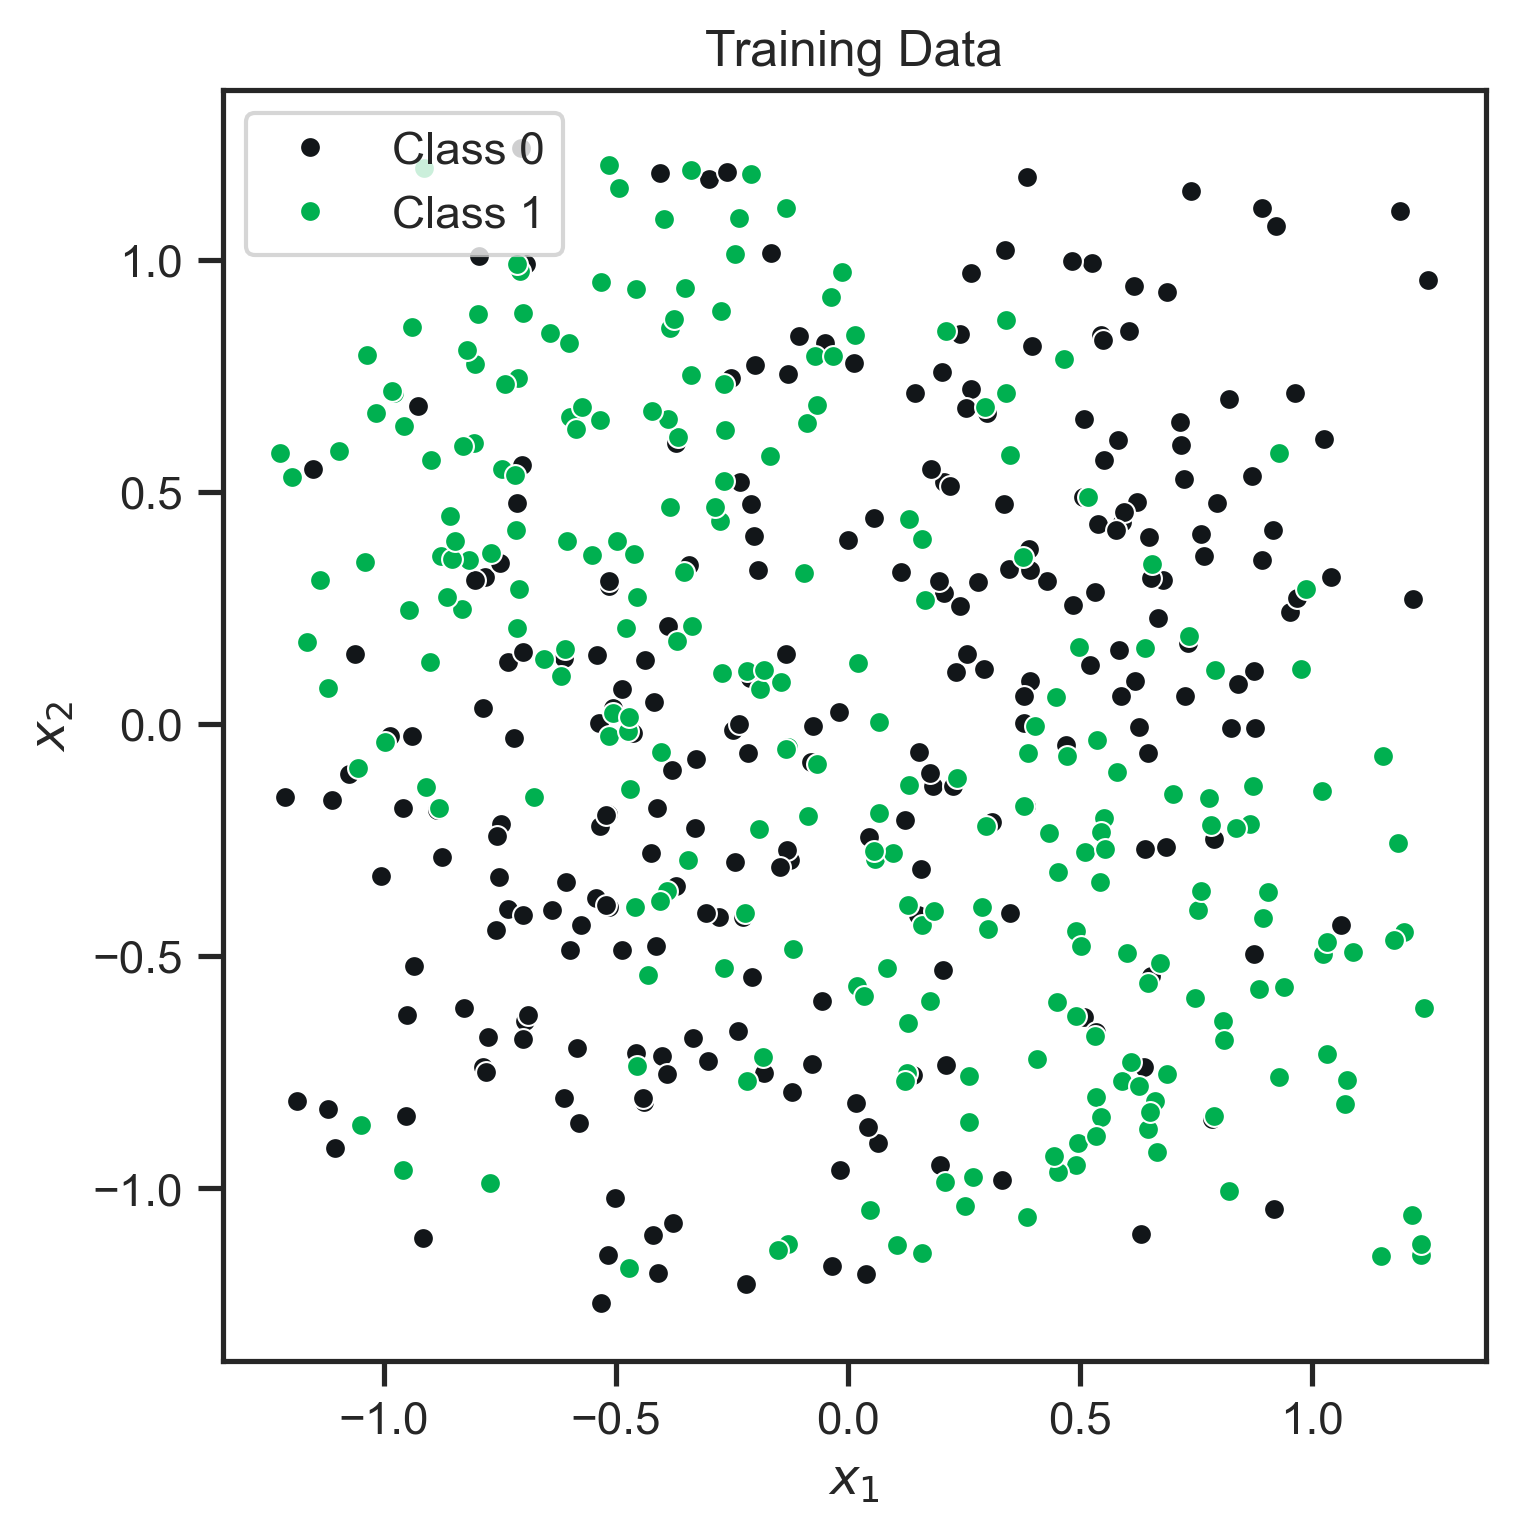

In [5]:
import matplotlib.pyplot as plt

# Code to plot the sample data
def plot_data(ax, X, y, title, limits):
    # Select the colors to use in the plots
    color0 = "#121619"  # Dark grey
    color1 = "#00B050"  # Green
    color_boundary = "#858585"

    # Separate samples by class
    samples0 = X[y == 0]
    samples1 = X[y == 1]

    ax.plot(
        samples0[:, 0],
        samples0[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 0",
    )
    ax.plot(
        samples1[:, 0],
        samples1[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 1",
    )
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.legend(loc="upper left")
    ax.set_aspect("equal")


fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, "Training Data", limits)


The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

This should produce 12 plots, altogether. For easier comparison, please plot nodes & layers combinations, learning rates, regularization strengths, and batch sizes in four separate rows (with three columns each representing a different value for each of those hyperparameters). 

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

> We create a helper function below to make drawing decision boundaries easier.

In [6]:
# Writing a helper function to draw decision boundaries
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(["cornflowerblue", "navajowhite"])
cmap_bold = ["midnightblue", "orange"]


def draw_decision_boundary(model, X, y, ax, xlabel, ylabel):
    """Draws decision boundary of a given model with X, y
    data, the axis to plot the graph on, as well as xlabel
    and ylabel for the plot"""
    DecisionBoundaryDisplay.from_estimator(
        model,
        X=X,
        y=y,
        ax=ax,
        cmap=cmap_light,
        xlabel=xlabel,
        ylabel=ylabel,
        shading="auto",
        response_method="predict",
    )
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=y,
        ax=ax,
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )


> Below, we fit 12 neural networks with the given hyperparameters and plot their decision boundaries on the training data.

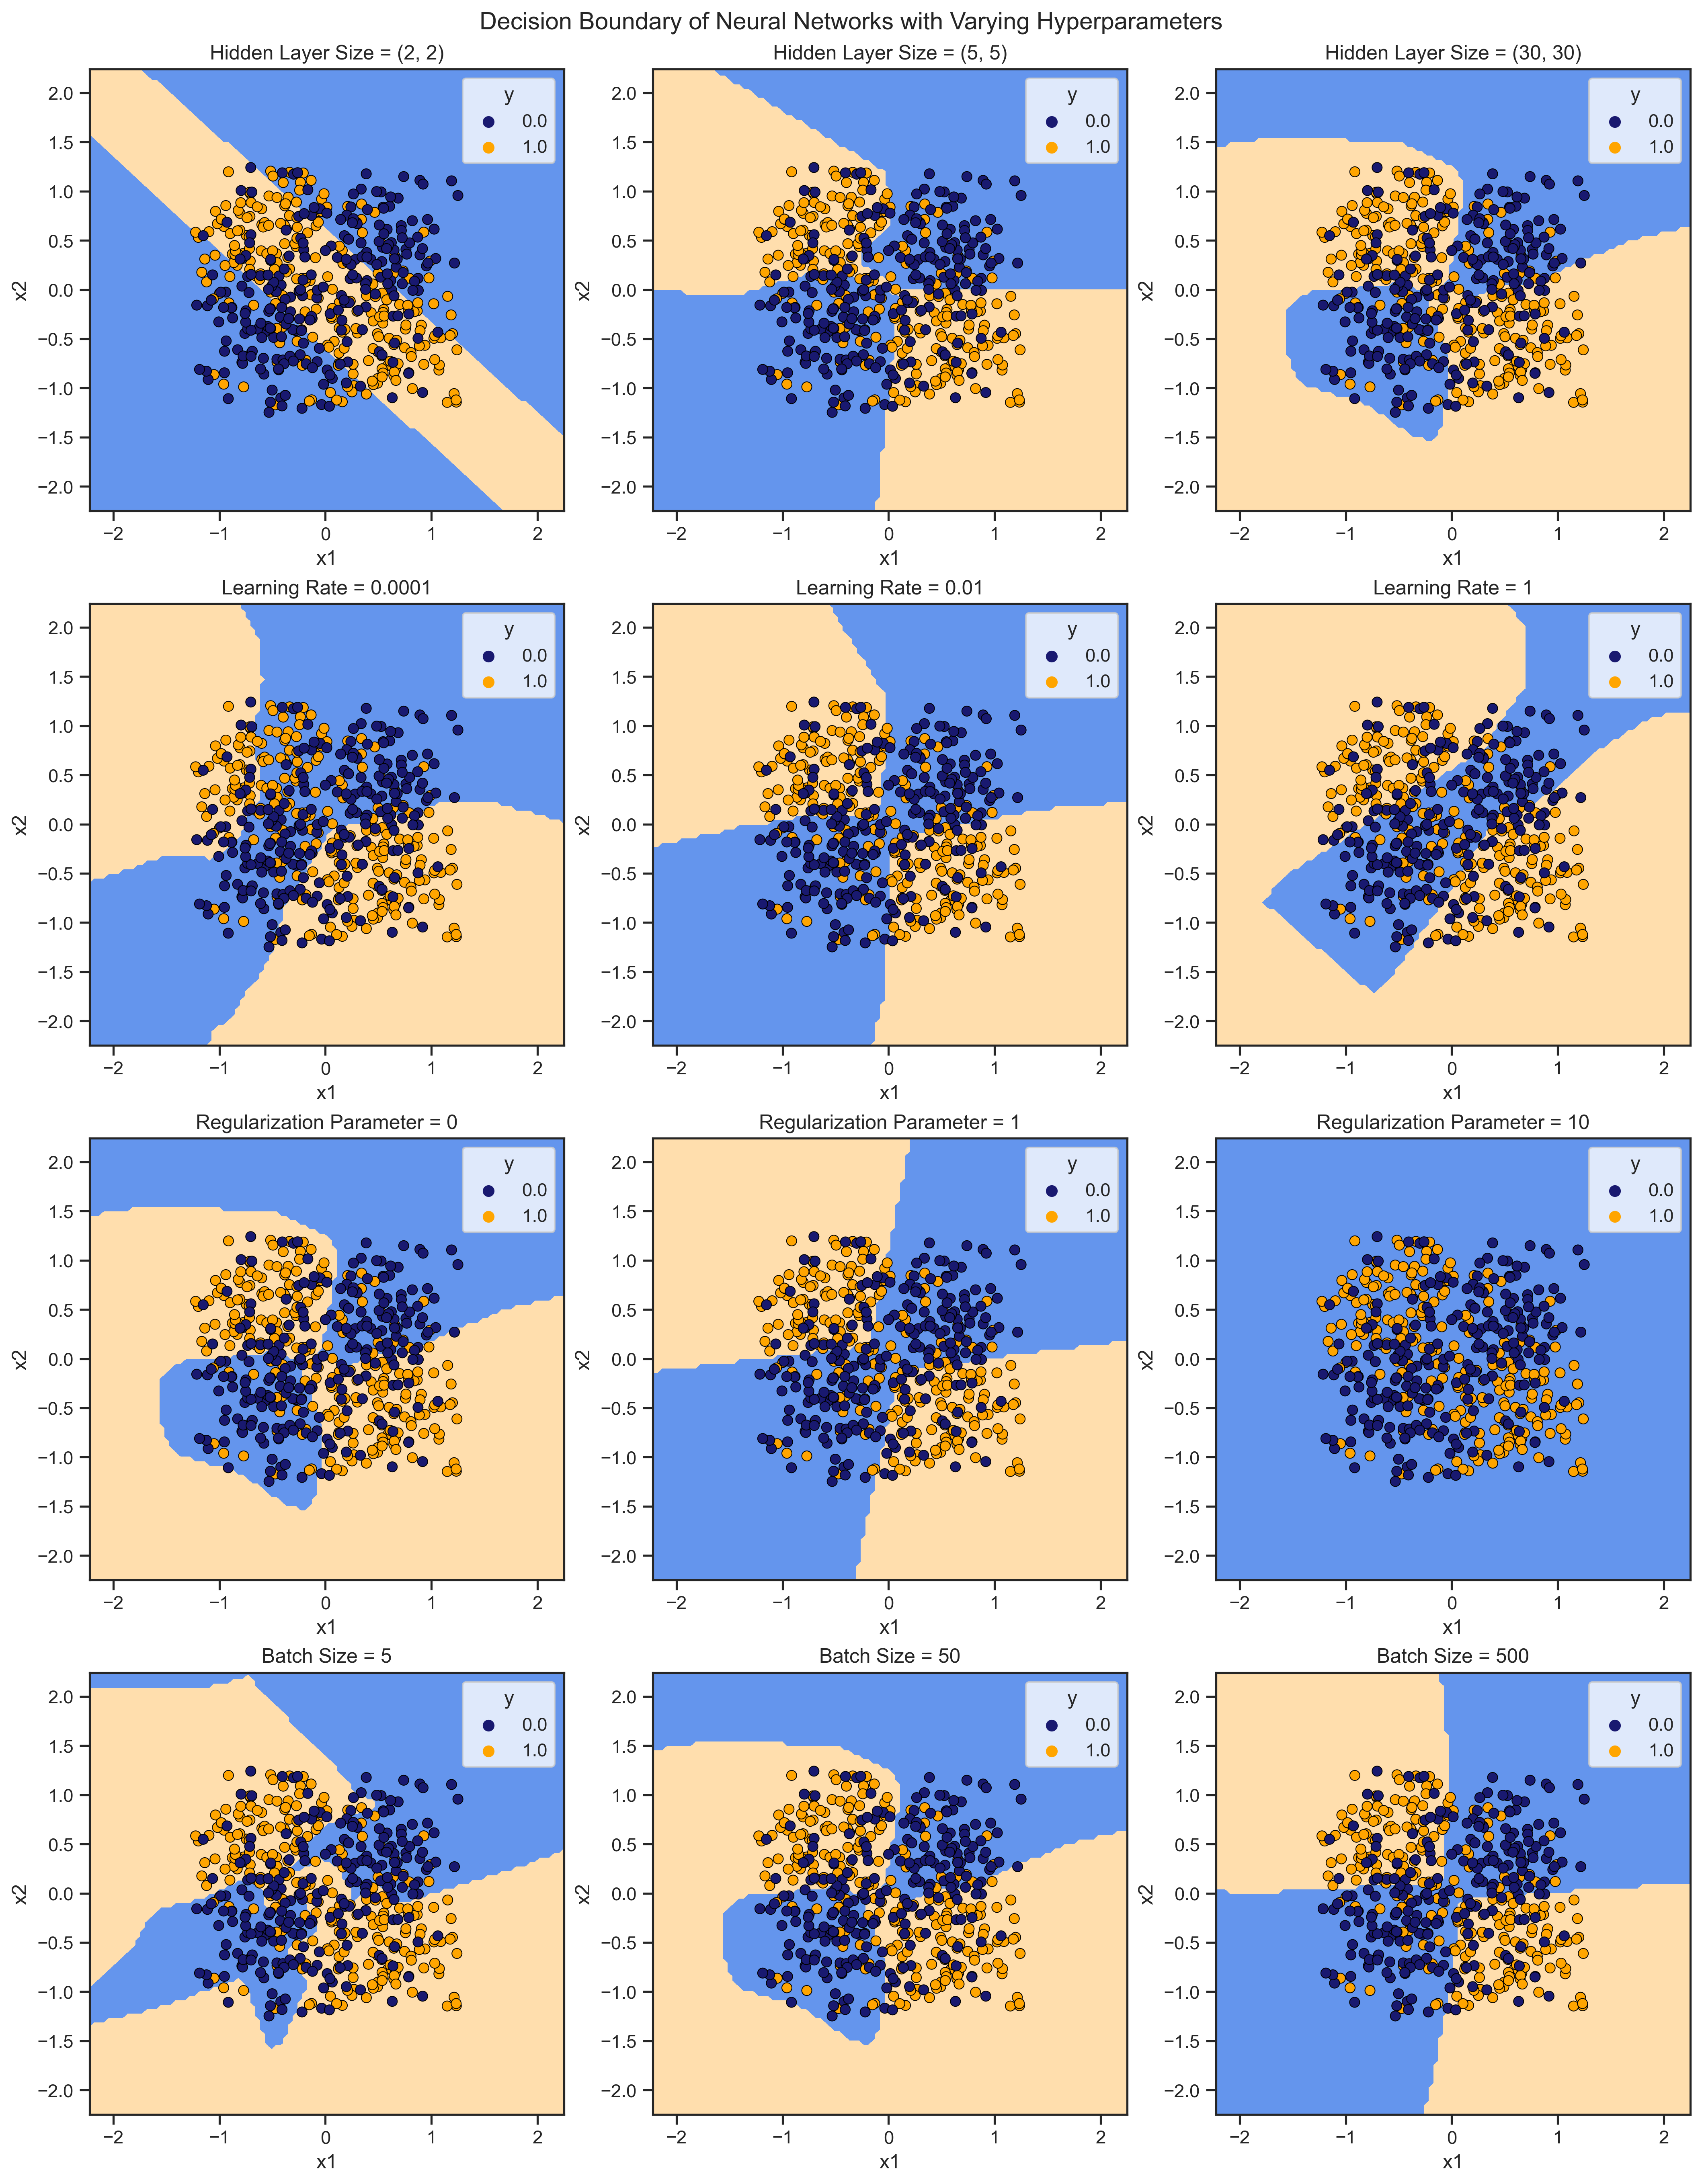

In [7]:
# Initialize the different hyperparameter choices
hidden_layer_size_a = [(2, 2), (5, 5), (30, 30)]
learning_rates_a = [0.0001, 0.01, 1]
regularizations_a = [0, 1, 10]
batch_sizes_a = [5, 50, 500]

# Train the neural networks
fig, axes = plt.subplots(nrows=4, ncols=3, constrained_layout=True, figsize=(14, 18))
from sklearn.neural_network import MLPClassifier

for column in range(3):
    # First row
    clf_1 = MLPClassifier(
        hidden_layer_sizes=hidden_layer_size_a[column],
        learning_rate_init=0.03,
        alpha=0,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=1000,
        batch_size=50,
        max_iter=500,
        random_state=4
    ).fit(X=X_train, y=y_train)
    draw_decision_boundary(clf_1, X_train, y_train, axes[0, column], "x1", "x2")
    axes[0, column].set_title(f"Hidden Layer Size = {hidden_layer_size_a[column]}")
    axes[0, column].legend(title="y")

    # Second row
    clf_2 = MLPClassifier(
        hidden_layer_sizes=(30, 30),
        learning_rate_init=learning_rates_a[column],
        alpha=0,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=1000,
        batch_size=50,
        max_iter=500,
        random_state=4
    ).fit(X=X_train, y=y_train)
    draw_decision_boundary(clf_2, X_train, y_train, axes[1, column], "x1", "x2")
    axes[1, column].set_title(f"Learning Rate = {learning_rates_a[column]}")
    axes[1, column].legend(title="y")

    # Third row
    clf_3 = MLPClassifier(
        hidden_layer_sizes=(30, 30),
        learning_rate_init=0.03,
        alpha=regularizations_a[column],
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=1000,
        batch_size=50,
        max_iter=500,
        random_state=4
    ).fit(X=X_train, y=y_train)
    draw_decision_boundary(clf_3, X_train, y_train, axes[2, column], "x1", "x2")
    axes[2, column].set_title(f"Regularization Parameter = {regularizations_a[column]}")
    axes[2, column].legend(title="y")

    # Four row
    clf_4 = MLPClassifier(
        hidden_layer_sizes=(30, 30),
        learning_rate_init=0.03,
        alpha=0,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=1000,
        batch_size=batch_sizes_a[column],
        max_iter=500,
        random_state=4
    ).fit(X=X_train, y=y_train)
    draw_decision_boundary(clf_4, X_train, y_train, axes[3, column], "x1", "x2")
    axes[3, column].set_title(f"Batch Size = {batch_sizes_a[column]}")
    axes[3, column].legend(title="y")
fig.suptitle("Decision Boundary of Neural Networks with Varying Hyperparameters")
plt.show()


**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times (without fixing a random seed) and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

> We create vectors of learning rates, regularization parameters, and batch sizes to iteratively feed into the MLP model.

In [8]:
learning_rate_vec = np.logspace(-5, 0, 20)
alpha_vec = np.logspace(-8, 2, 20)
batch_sizes_vec = [1, 3, 5, 10, 20, 50, 100, 250, 500]
iterations = 5

learning_rate_scores = np.empty([iterations, 20])
alpha_scores = np.empty([iterations, 20])
batch_sizes_scores = np.empty([iterations, 9])


> For each hyperparameter we try, we fit the model 5 times to consider randomness associated with the initialization of the model. We then take the average of the model accuracy on the validation data from each of the 5 fits. 

In [9]:
# Fit Neural Networks with Varying Learning Rates
np.random.seed(4)
for iter in range(iterations):
    for ind, lr in enumerate(learning_rate_vec):
        clf = MLPClassifier(
            hidden_layer_sizes=(30, 30),
            learning_rate_init=lr,
            alpha=0,
            solver="sgd",
            tol=1e-5,
            early_stopping=False,
            activation="relu",
            n_iter_no_change=1000,
            batch_size=50,
            max_iter=500,
        ).fit(X=X_train, y=y_train)
        learning_rate_scores[iter, ind] = clf.score(X_val, y_val)

# Take the mean across rows
learning_rate_scores = learning_rate_scores.mean(axis=0)


In [10]:
# Fit Neural Networks with Varying Regularization Parameters
np.random.seed(4)
for iter in range(iterations):
    for ind, alpha in enumerate(alpha_vec):
        clf = MLPClassifier(
            hidden_layer_sizes=(30, 30),
            learning_rate_init=0.03,
            alpha=alpha,
            solver="sgd",
            tol=1e-5,
            early_stopping=False,
            activation="relu",
            n_iter_no_change=1000,
            batch_size=50,
            max_iter=500,
        ).fit(X=X_train, y=y_train)
        alpha_scores[iter, ind] = clf.score(X_val, y_val)

# Take the mean across rows
alpha_scores = alpha_scores.mean(axis=0)


In [11]:
# Fit Neural Networks with Varying Batch Sizes
np.random.seed(4)
for iter in range(iterations):
    for ind, size in enumerate(batch_sizes_vec):
        clf = MLPClassifier(
            hidden_layer_sizes=(30, 30),
            learning_rate_init=0.03,
            alpha=0,
            solver="sgd",
            tol=1e-5,
            early_stopping=False,
            activation="relu",
            n_iter_no_change=1000,
            batch_size=size,
            max_iter=500,
        ).fit(X=X_train, y=y_train)
        batch_sizes_scores[iter, ind] = clf.score(X_val, y_val)

# Take the mean across rows
batch_sizes_scores = batch_sizes_scores.mean(axis=0)


> After we have obtained the model accuracies as a function of the model's learning rate, regularization parameter, and batch size, we plot the three lines on three different axes. Using the plot, we can pick the hyperparameter that yielded the best accuracy on validation data.

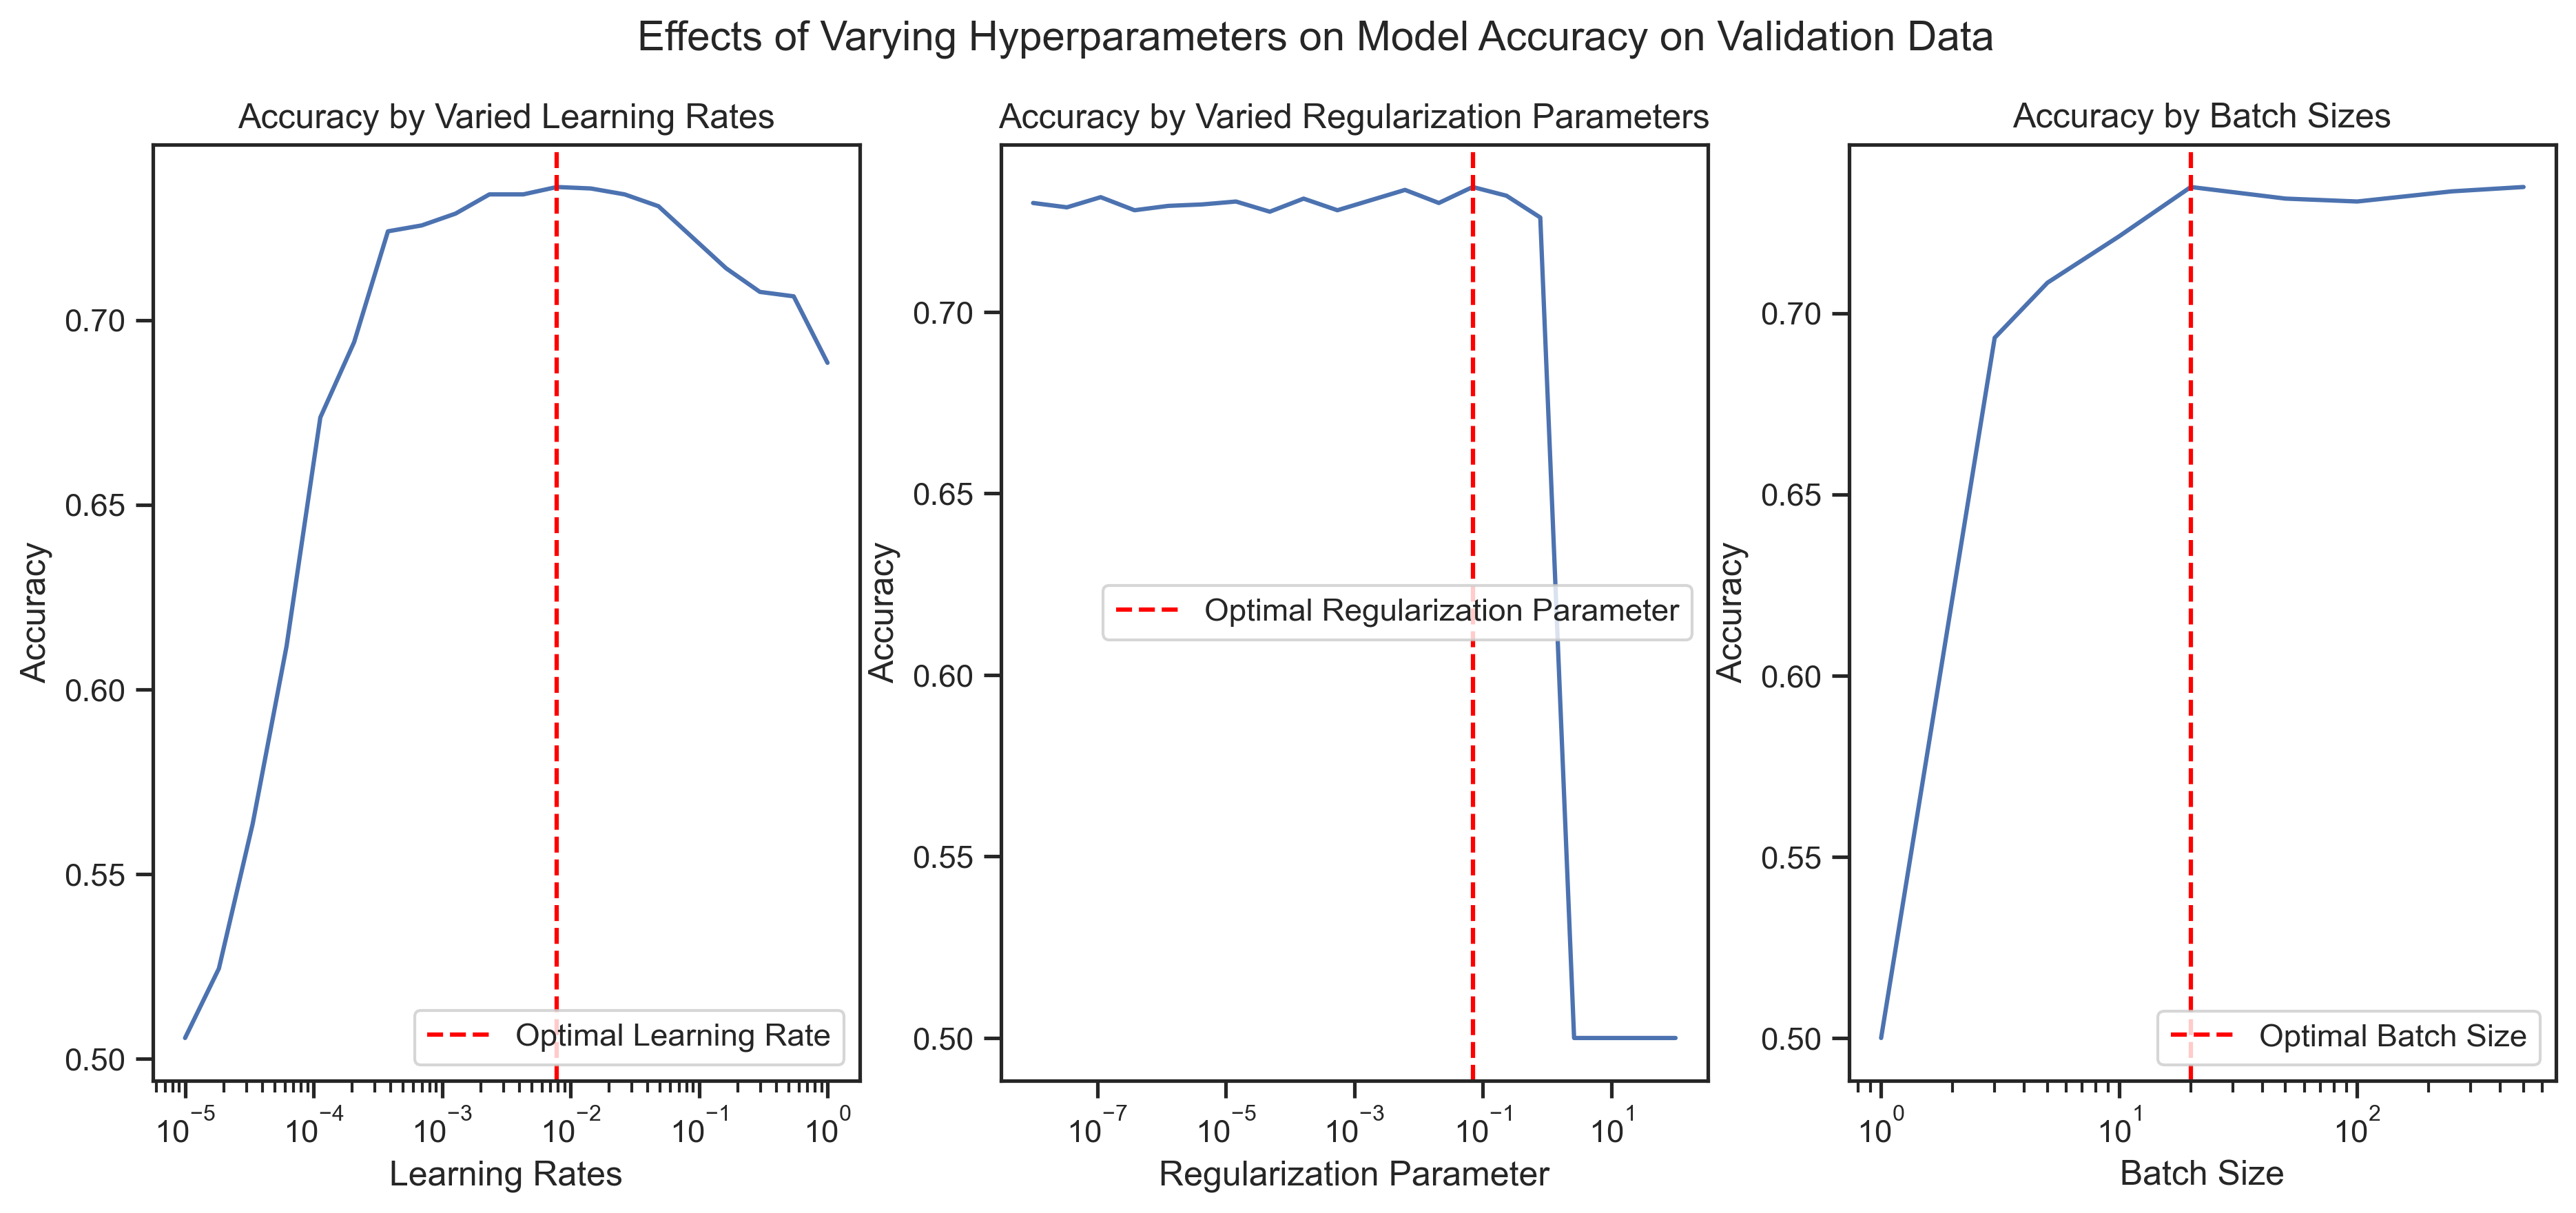

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
# Plot accuracy from learning rates
optimal_lr = learning_rate_vec[learning_rate_scores.argmax()]
axes[0].plot(learning_rate_vec, learning_rate_scores)
axes[0].set_xscale("log")
axes[0].axvline(x=optimal_lr, linestyle="--", c="red", label="Optimal Learning Rate")
axes[0].legend()
axes[0].set_xlabel("Learning Rates")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy by Varied Learning Rates")

# Plot accuracy from regularization parameters
axes[1].plot(alpha_vec, alpha_scores)
axes[1].set_xscale("log")
optimal_alpha = alpha_vec[alpha_scores.argmax()]
axes[1].axvline(
    x=optimal_alpha, linestyle="--", c="red", label="Optimal Regularization Parameter"
)
axes[1].legend()
axes[1].set_xlabel("Regularization Parameter")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy by Varied Regularization Parameters")

# Plot accuracy from batch sizes
axes[2].plot(batch_sizes_vec, batch_sizes_scores)
axes[2].set_xscale("log")
axes[2].axvline(x=20, linestyle="--", c="red", label="Optimal Batch Size")
axes[2].legend()
axes[2].set_xlabel("Batch Size")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Accuracy by Batch Sizes")

fig.suptitle("Effects of Varying Hyperparameters on Model Accuracy on Validation Data")
plt.show()


In [13]:
print(f"The optimal learning rate is {optimal_lr:.4f}.")
print(f"The optimal regularization parameter is {optimal_alpha:.4f}.")


The optimal learning rate is 0.0078.
The optimal regularization parameter is 0.0695.


> We vary hyperparameters and fit multiple fits and take the average accuracy of the model for all different variations of hyperparameters. For the learning rates, we pick the smallest learning rate that would give us a high enough accuracy – in this case we choose the learning rate that stabiliy yields the highest accuracy: 0.0078. 
>
>We do the same thing for the regularization parameter: we don't want the alpha value to be too small so as to let the model overfit, or so large that it increases bias, so we choose the regularization parameter with the highest validation accuracy: where alpha = 0.0695. 
>
> For the model batch size, we want to make the batch size minimal to increase computational efficiency without incurring a cost on our model acuracy. Therefore, we look at the plot and pick a low batch size value that gives us high accuracy: in this case batch size = 20.

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

> We create a list of nodes and a list of layers to try out in our MLPClassifier. We use `np.tile` to construct the layer sizes and fit them iteratively. Getting a matrix of accuracy scores with their rows corresponding to the number of layers in the classifier, and columns the number of nodes.

In [14]:
# Create lists of nodes and layers we need to fit
nodes = [1, 2, 3, 4, 5, 10, 15, 25, 30]
layers = [1, 2, 3, 4]

# Initialize an array to store accuracies
node_layer_accuracy = np.empty((len(layers), len(nodes)))

# Iterate over each node and layer
# Fit and score the neural entworks
for row, layer in enumerate(layers):
    for col, node in enumerate(nodes):
        clf = MLPClassifier(
            hidden_layer_sizes=np.tile(node, layer),
            learning_rate_init=0.03,
            alpha=0,
            solver="sgd",
            tol=1e-5,
            early_stopping=False,
            activation="relu",
            n_iter_no_change=1000,
            batch_size=size,
            max_iter=500,
            random_state=4
        ).fit(X=X_train, y=y_train)
        node_layer_accuracy[row, col] = clf.score(X_val, y_val)


> After obtaining the matrix, we are able to construct the heatmap of the accuracies.

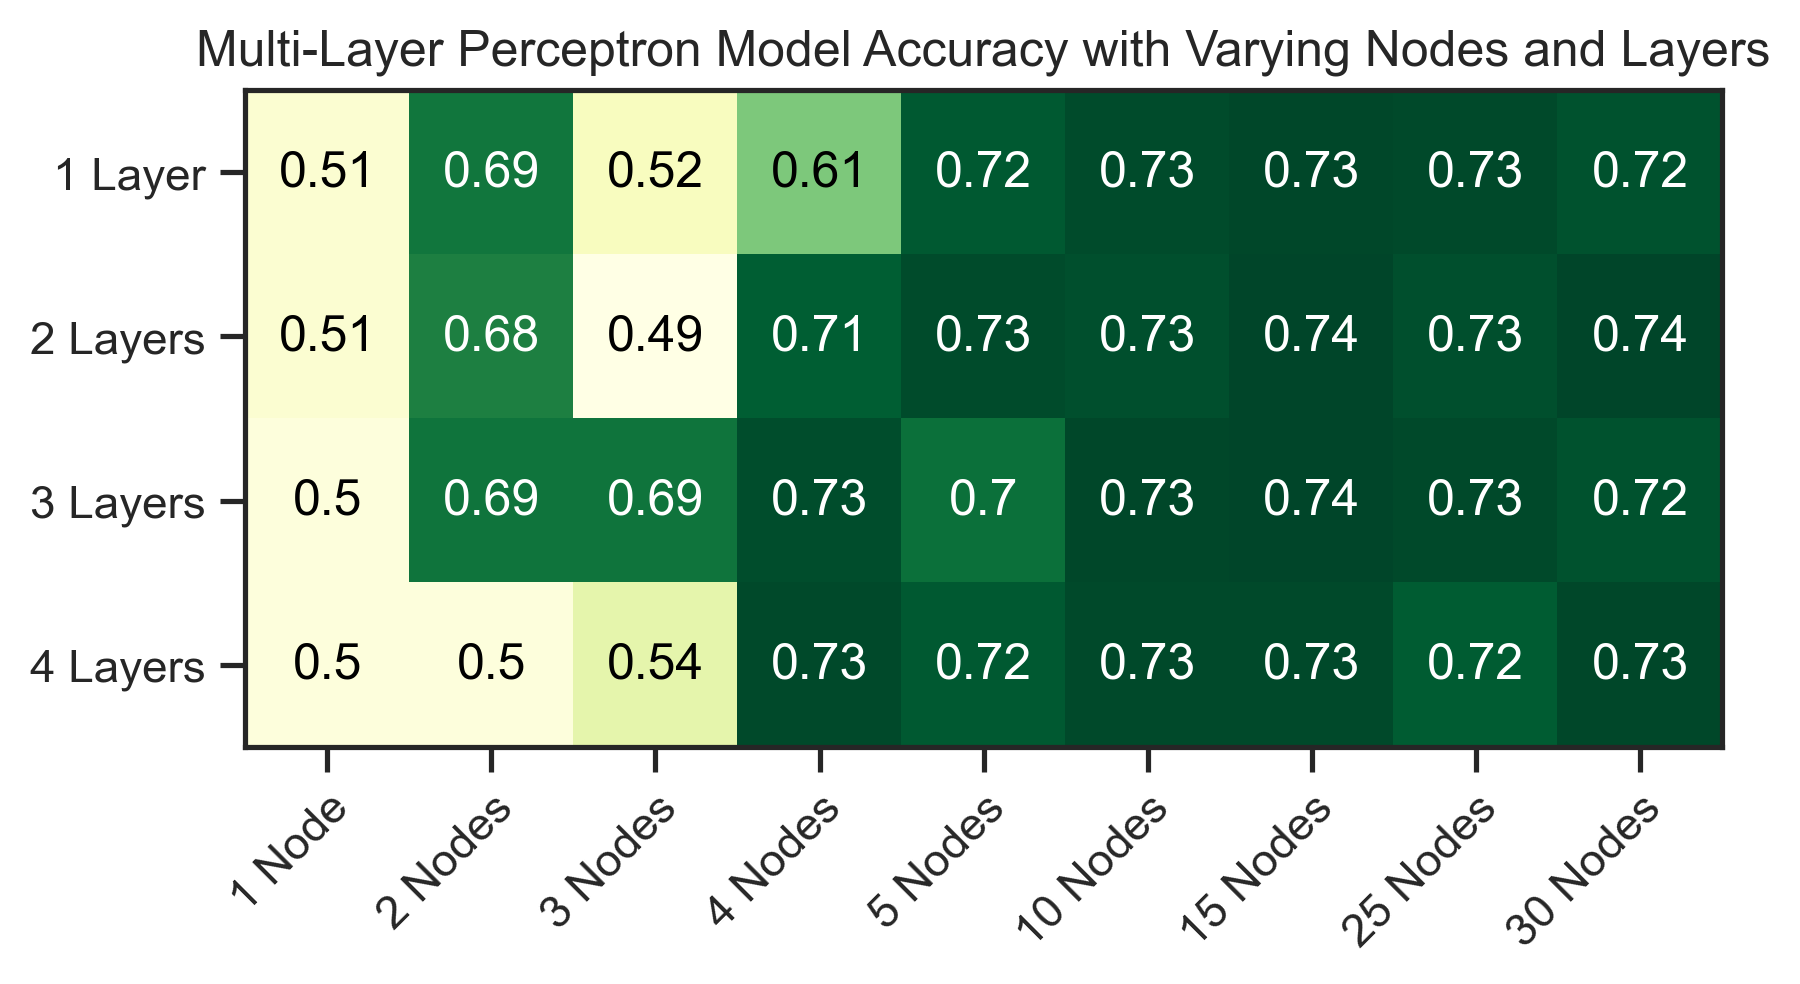

In [15]:
# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(node_layer_accuracy, cmap="YlGn")

# Set ticks and labels
ax.set_xticks(
    np.arange(len(nodes)),
    labels=[
        "1 Node",
        "2 Nodes",
        "3 Nodes",
        "4 Nodes",
        "5 Nodes",
        "10 Nodes",
        "15 Nodes",
        "25 Nodes",
        "30 Nodes",
    ],
)
ax.set_yticks(
    np.arange(len(layers)), labels=["1 Layer", "2 Layers", "3 Layers", "4 Layers"]
)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Get threshold to set text colors
threshold = im.norm(node_layer_accuracy.max()) / 2

# Set text annotation of heatmap
textcolors = ("black", "white")
for i in range(len(layers)):
    for j in range(len(nodes)):
        text = ax.text(
            j,
            i,
            node_layer_accuracy[i, j].round(2),
            ha="center",
            va="center",
            color=textcolors[int(im.norm(node_layer_accuracy[i, j]) > threshold)],
        )

ax.set_title("Multi-Layer Perceptron Model Accuracy with Varying Nodes and Layers")
fig.tight_layout()
plt.show()


> As we can see in the heatmap above, as the total number of nodes increase, the accuracy of our neural network model also increases. However, as the number of layers and nodes increase, the model accuracy decreases slightly, indicating that it may be overfitting on validation data. The lowest layer-node combination that achieves the highest accuracy is a model with 2 layers and 15 nodes, which givs us an accuracy of 74% with 30 nodes in total. We pick this combination because it is the simplest model yielding the highest result.

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

The accuracy of the final model on test data is 0.73.


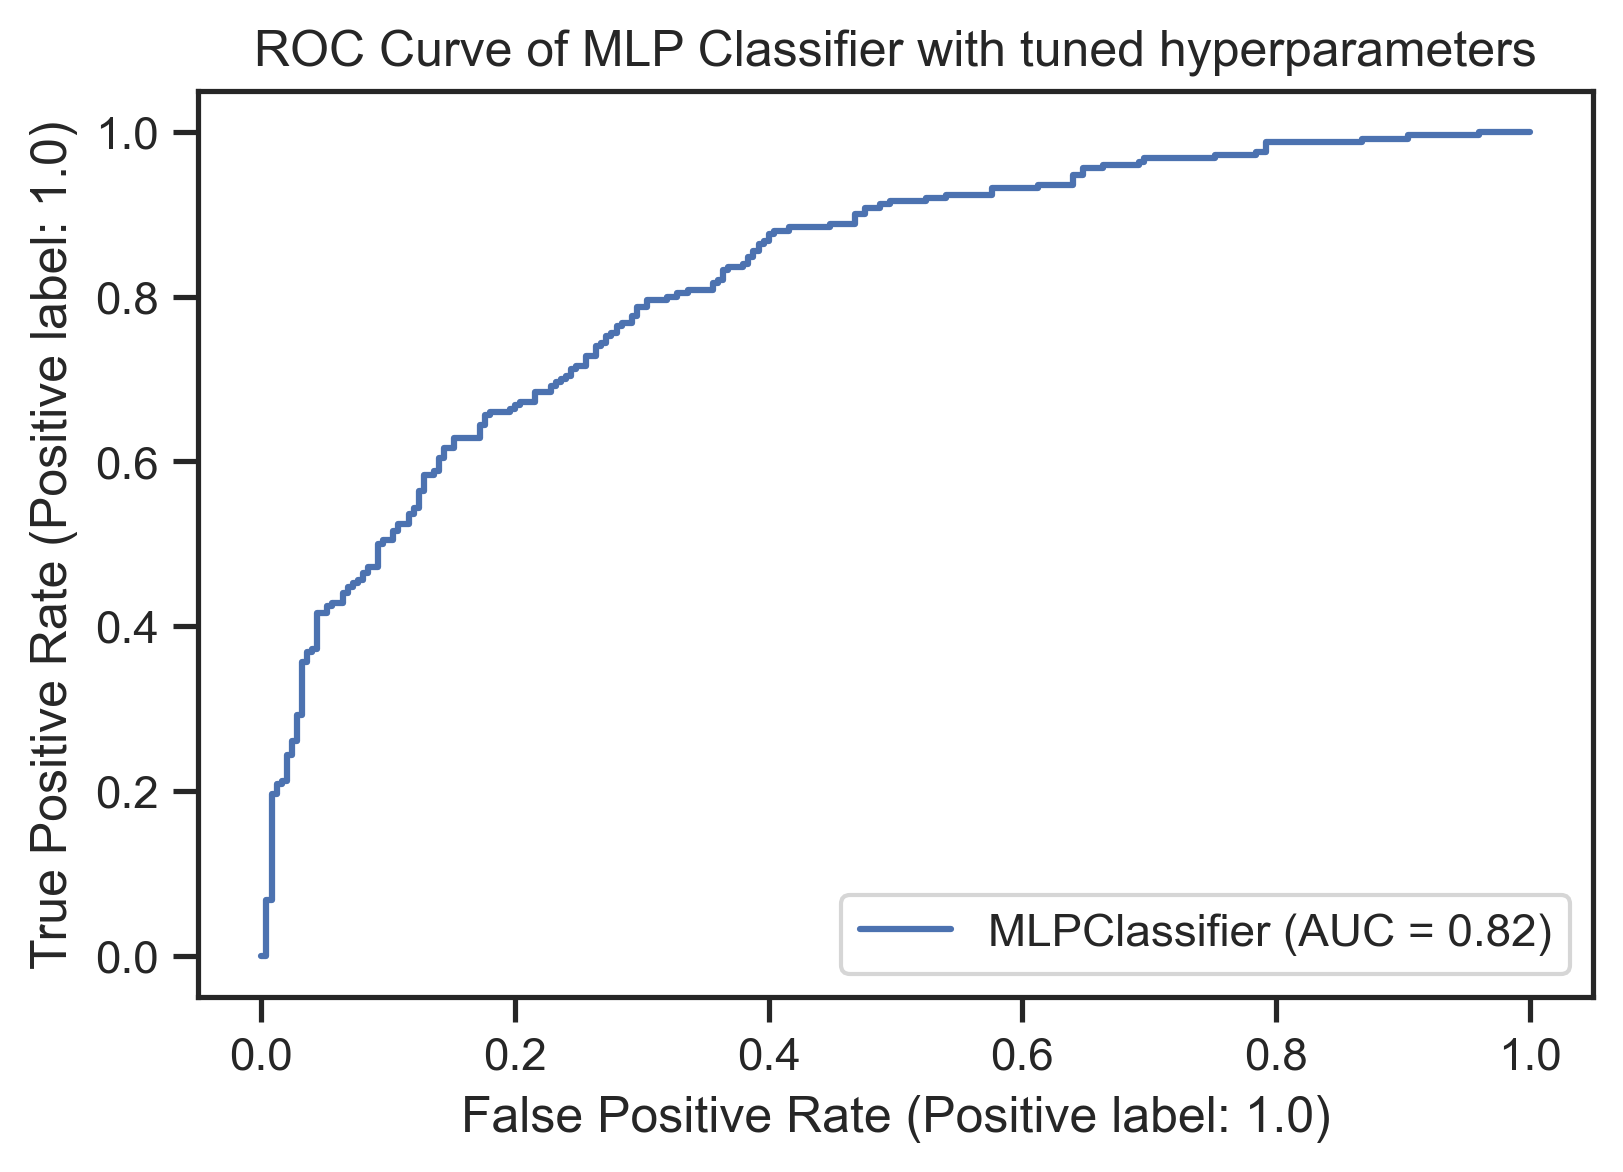

In [16]:
# -----------------------------------------------------------------------------
# Train model on training data and validation data
# -----------------------------------------------------------------------------
model_d = MLPClassifier(
    hidden_layer_sizes=(15,15),
    learning_rate_init=optimal_lr,
    alpha=optimal_alpha,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=1000,
    batch_size=20,
    max_iter=500,
).fit(X=X_train_plus_val, y=y_train_plus_val)
# -----------------------------------------------------------------------------
# Apply model to test data and print accuracy of final model
# -----------------------------------------------------------------------------
test_acc_d = model_d.score(X_test, y_test)
print(
    f"The accuracy of the final model on test data is {test_acc_d:.2f}."
)
# -----------------------------------------------------------------------------
# Plot ROC curve
# -----------------------------------------------------------------------------
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(
    estimator=model_d, 
    X=X_test,
    y=y_test,
)
plt.title("ROC Curve of MLP Classifier with tuned hyperparameters")
plt.show()

**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally known. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve. This should be one single graph with 3 curves (one for greedy search, one for random search, and one representing random chance). Please also provide AUC score for greedy research and random search. 
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

> Using scipy's loguniform, we construct a log uniform distribution for learning rates and the regularization parameters. After we created the distributions of parameters, we create the classifier and instantialize the RandomizedSearchCV model, fitting it on the training plus validation data with specified cross-validation split.

In [17]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

# -----------------------------------------------------------------------------
# Set search variables
# -----------------------------------------------------------------------------
learning_rate_dist = loguniform(1e-5,1e0)
alpha_dist = loguniform(1e-8,1e2)
hidden_layers = [
    tuple(np.tile(node, layer))
    for node in nodes
    for layer in layers
]
batch_sizes = [1, 3, 5, 10, 20, 50, 100, 250, 500]
param_dist = {
    "hidden_layer_sizes":hidden_layers,
    "learning_rate_init":learning_rate_dist,
    "alpha":alpha_dist,
    "batch_size":batch_sizes
}

# -----------------------------------------------------------------------------
# Fit the RandomizedSearchCV algorithm
# -----------------------------------------------------------------------------

# Create the classifier model
random_search_model = MLPClassifier(
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=1000,
    max_iter=500,
    random_state=44
)

# Create the search model
random_search = RandomizedSearchCV(
    random_search_model,
    param_distributions=param_dist, 
    n_iter=200,
    n_jobs=-1,
    cv = train_val_split
)

# Fit the data
random_search.fit(
    X_train_plus_val, y_train_plus_val
)

# Get the best model through the random_search algorithm
best_model = random_search.best_estimator_


> Reporting the accuracy of our randomized search model on test data as well as the optimal hyperparameters:

In [18]:
print(
    "The model with the best hyperparameters derived through"
    " randomized search has an accuracy of "
    f"{best_model.score(X_test, y_test):.2f} "
    "on the test data."
)
print(
    "\n",
    "Below are the optimal hyperparameters from randomized search: "
    "\n",
    "hidden_layer_sizes=",
    random_search.best_params_["hidden_layer_sizes"],
    "\n",
    "learning_rate_init=",
    random_search.best_params_["learning_rate_init"].round(3),
    "\n",
    "alpha=",
    random_search.best_params_["alpha"].round(4),
    "\n",
    "batch_size=",
    random_search.best_params_["batch_size"]
)

The model with the best hyperparameters derived through randomized search has an accuracy of 0.72 on the test data.

 Below are the optimal hyperparameters from randomized search: 
 hidden_layer_sizes= (3, 3, 3) 
 learning_rate_init= 0.005 
 alpha= 0.0 
 batch_size= 3


> Using the above hyperparameters, we can fit the tuned model from randomized search cross validation and compare its performance to the model we obtained from grid search cross validation.

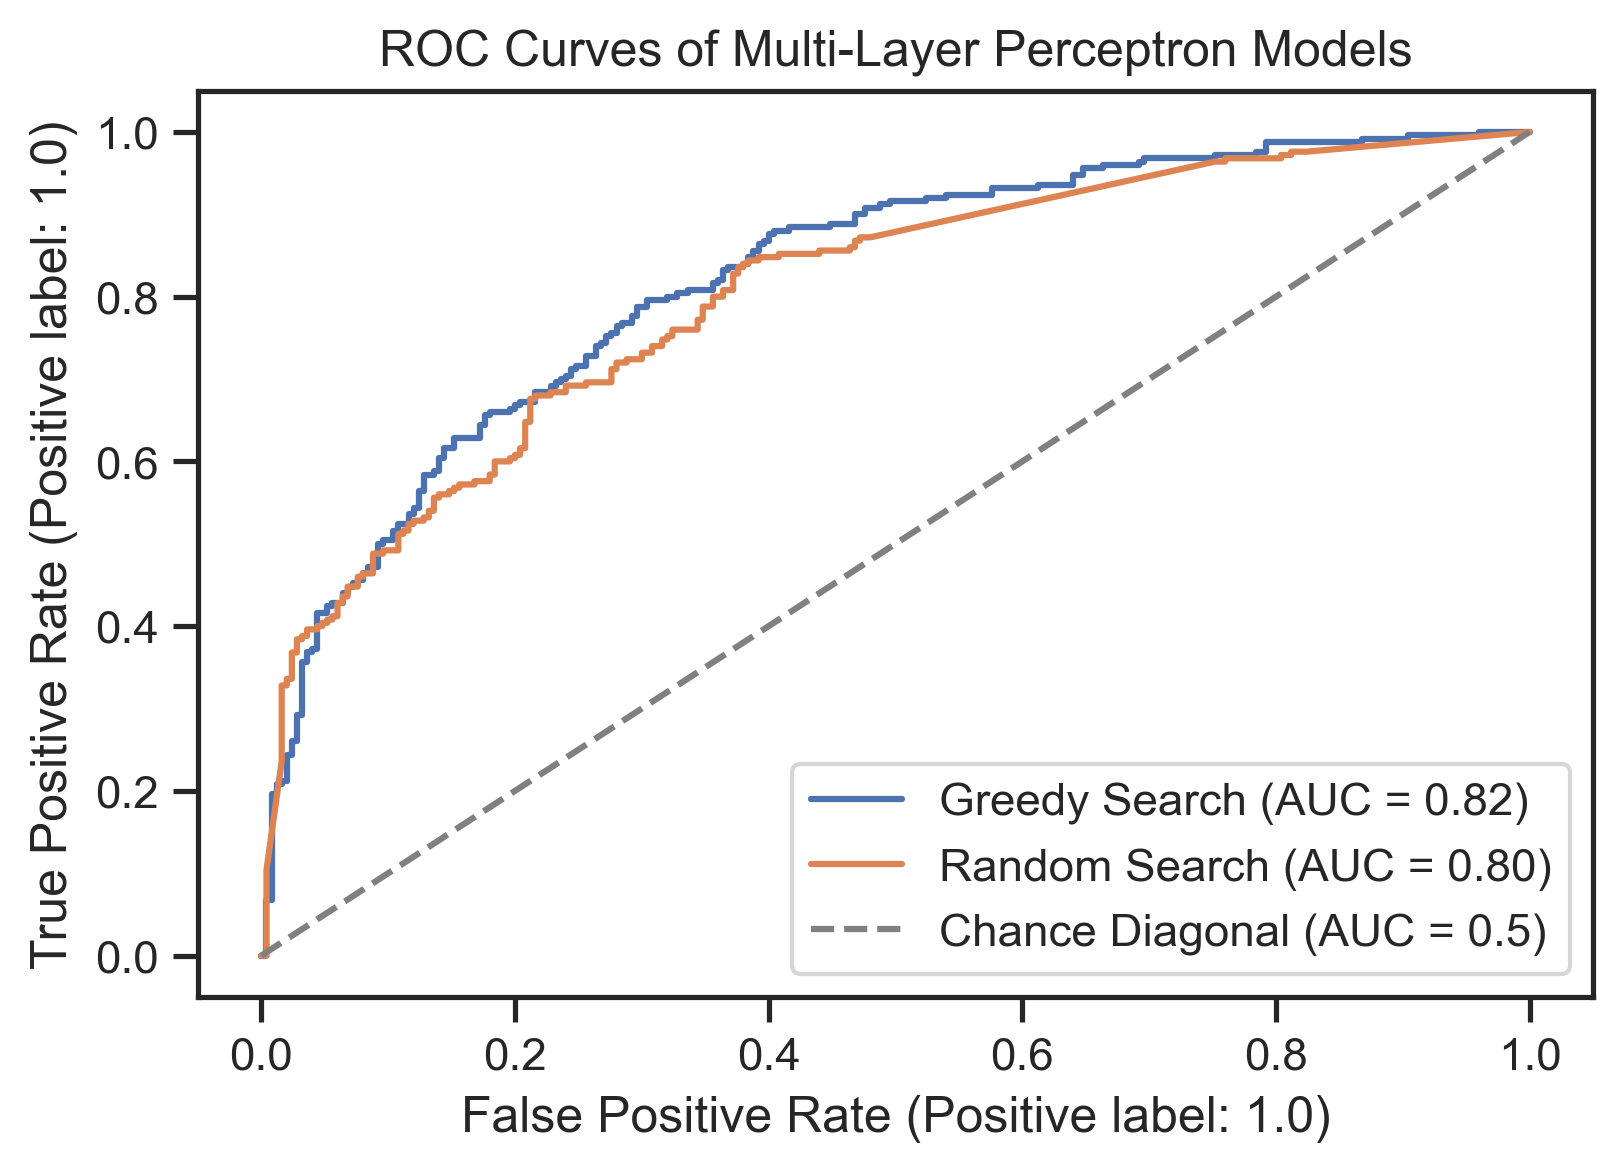

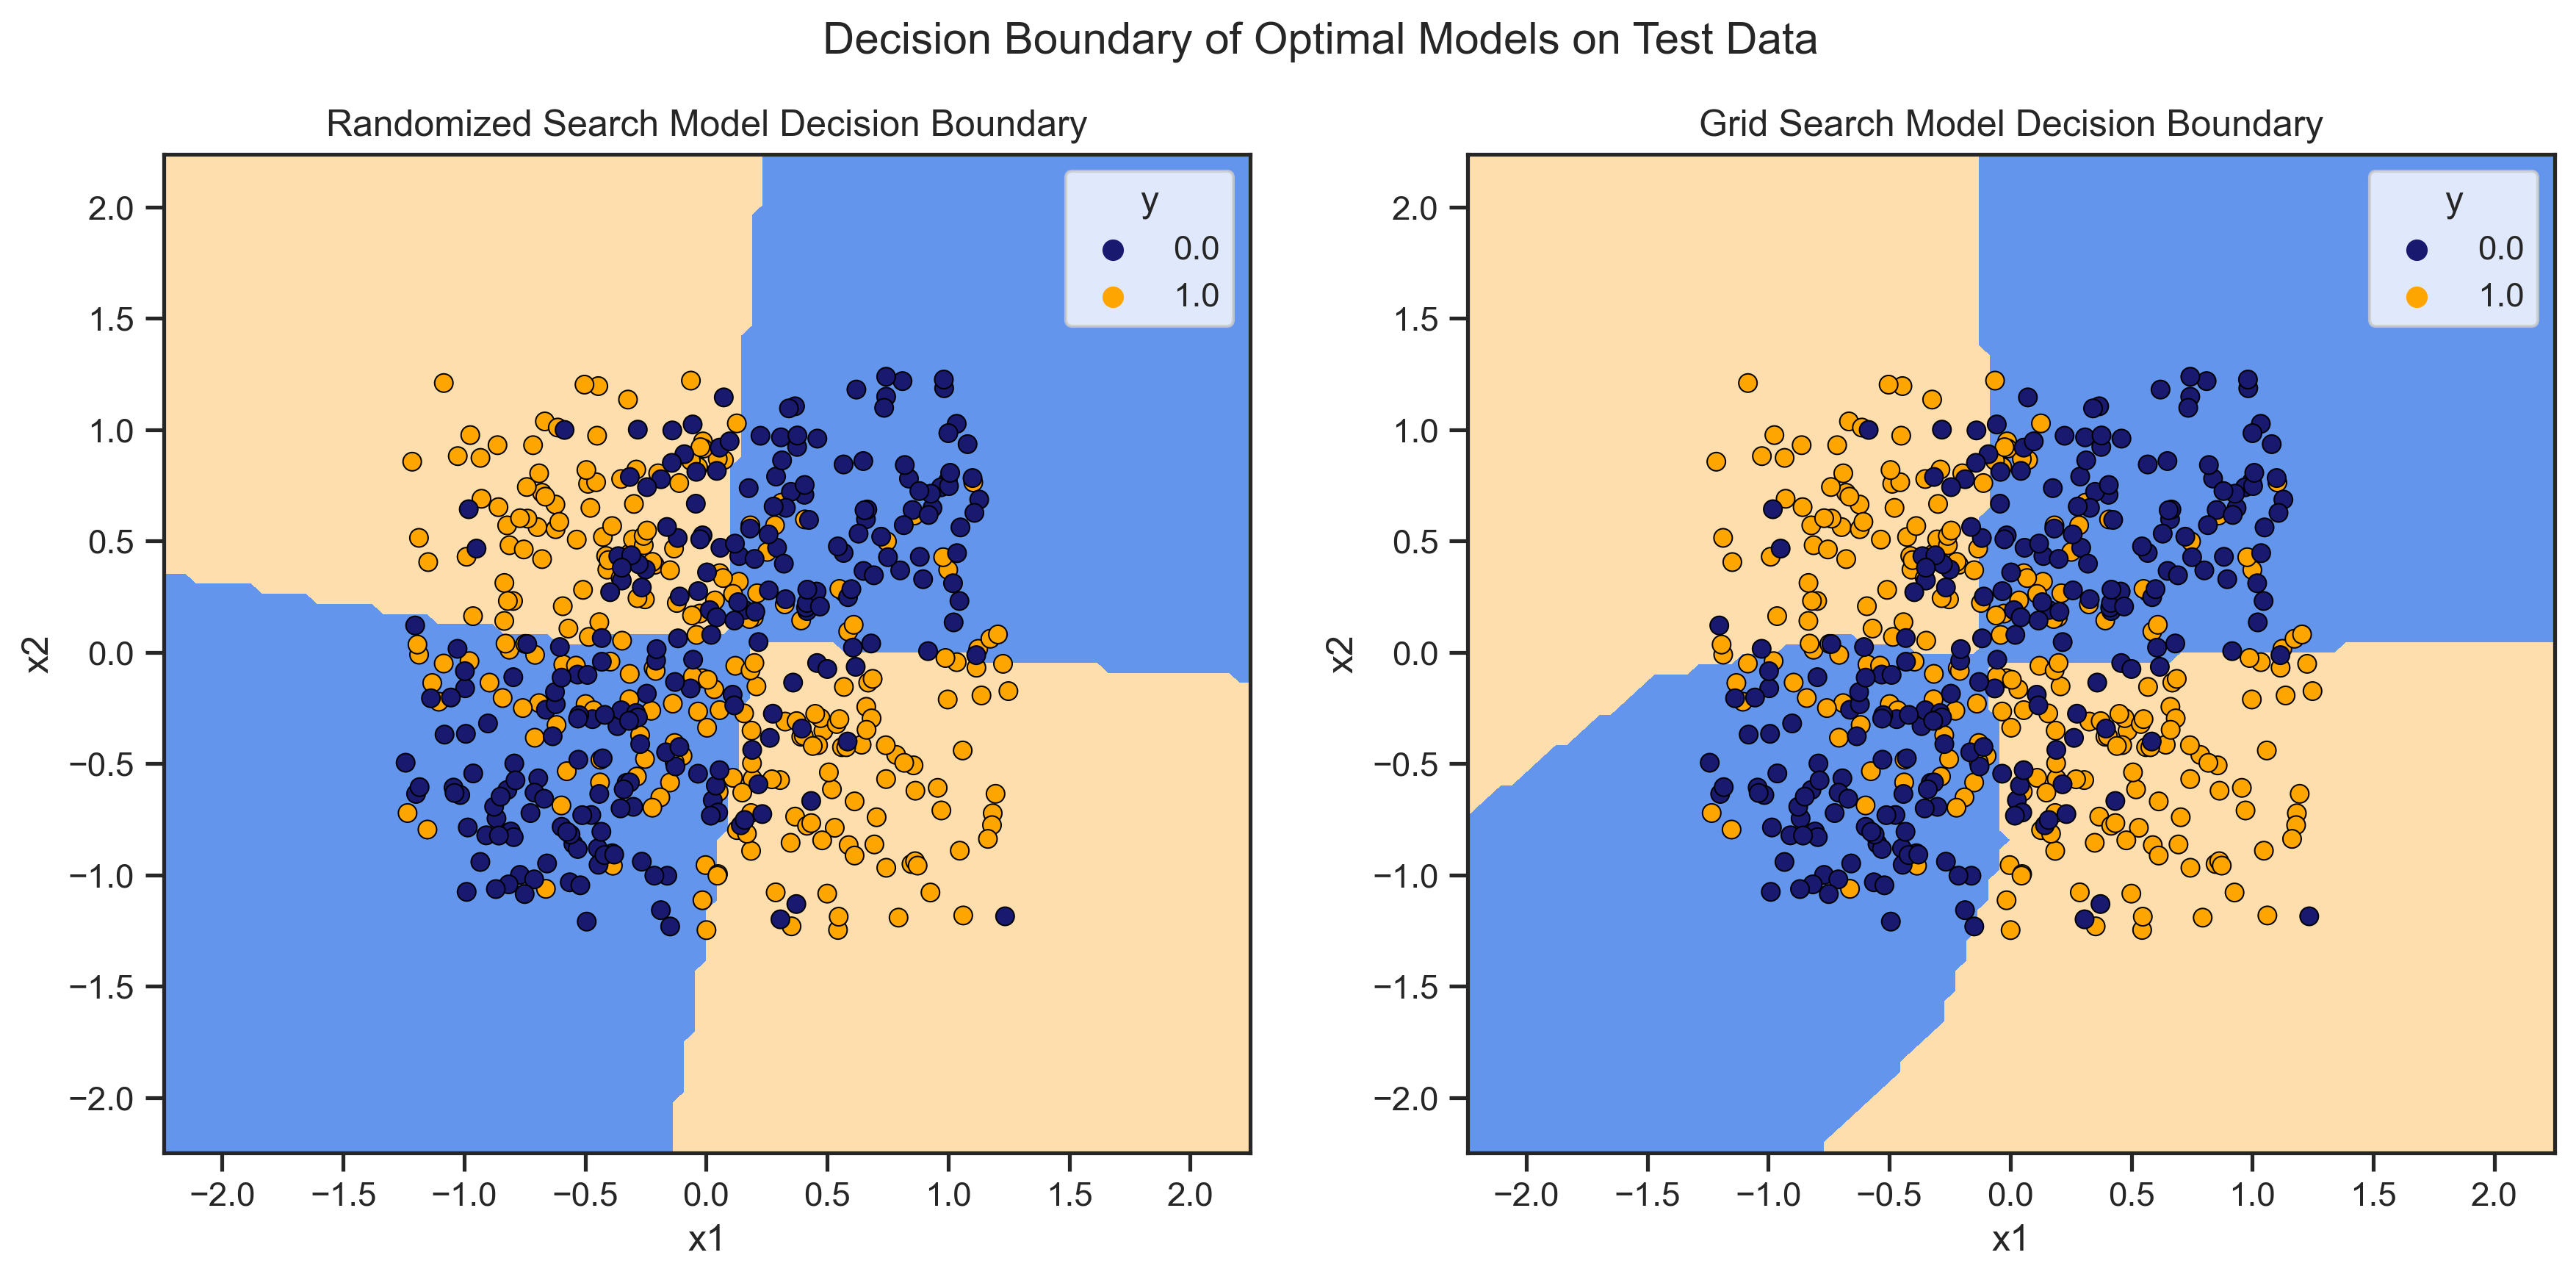

In [19]:
# -----------------------------------------------------------------------------
# Plot ROC Curve and decision boudnary
# -----------------------------------------------------------------------------
fig, ax = plt.subplots()

# Create chance diagonal
chance = np.stack((np.linspace(0, 1, 500), np.linspace(0, 1, 500)), axis=1)

#Plot ROC curves
RocCurveDisplay.from_estimator(
    model_d,
    X_test,
    y_test,
    ax = ax,
    name = "Greedy Search"
)
RocCurveDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    ax = ax,
    name = "Random Search"
)
ax.plot(
    chance[:, 0], chance[:, 1], linestyle="dashed", 
    c="gray", label="Chance Diagonal (AUC = 0.5)"
)
ax.set_title("ROC Curves of Multi-Layer Perceptron Models")
ax.legend()
plt.show()

# Plot Decision Boundary of Random Search Model and Grid Search Model
fig, axes = plt.subplots(1,2, figsize = (14,6))
# Plot decision boundary of random search model
draw_decision_boundary(best_model, X_test, y_test, axes[0], "x1", "x2")
axes[0].set_title("Randomized Search Model Decision Boundary")
axes[0].legend(title="y")
# Plot decision boundary of grid search model
draw_decision_boundary(model_d, X_test, y_test, axes[1], "x1", "x2")
axes[1].set_title("Grid Search Model Decision Boundary")
axes[1].legend(title="y")
fig.suptitle("Decision Boundary of Optimal Models on Test Data")
plt.show()

> The model with hyperparameters we got from grid search performs on par with the model with hyperparameters from greedy search. The accuracy of the random search model (0.74) was slightly higher than the accuracy of the greedy search model (0.73) on the test data, but the AUC was slightly higher for the grid search model on test data. The differences are miniscule, so the two models generalize about equally well to test data. However, looking at the decision boundary plots, we find that the grid search model comforms to the checkerbox pattern we used to generate to the data, wheras randomized search model does not as well. That, pointing to better generalizability, may be a consideration in choosing the grid search model over the randomized model.

# 2 {-}

## [30 points] Build and test your own Neural Network for classification {-}

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a) [10 points of the 30]** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**NOTE: Due to the depth this question requires, some students may choose not to complete this section (in lieu of receiving the 10 points from this question). If you choose not to build your own neural network, or if your neural network is not functional prior to submission, then use the `scikit-learn` implementation instead in the questions below; where it asks to compare to `scikit-learn`, compare against a random forest classifier instead.**

In [20]:
# neural network class skeleton code

class myNeuralNetwork(object):
    
    def __init__(self, n_in, n_layer1, n_layer2, n_out, learning_rate=0.03):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs, 
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        '''
        # Initialize weights of model
        self.W1 = np.random.random((n_layer1, n_in))
        self.W2 = np.random.random((n_layer2, n_layer1))
        self.W3 = np.random.random((n_out, n_layer2))

        # Set placeholders for activations, inputs, deltas, weight gradients
        self.inputs = np.empty((n_in, 1))
        self.A1 = np.empty((n_layer1, 1))
        self.A2 = np.empty((n_layer2, 1))
        self.A3 = np.empty((n_out, 1))
        self.Z1 = np.empty((n_layer1, 1))
        self.Z2 = np.empty((n_layer2, 1))
        self.Z3 = np.empty((n_out, 1))
        self.delta1 = np.empty((n_layer1, 1))
        self.delta2 = np.empty((n_layer2, 1))
        self.delta3 = np.empty((n_out, 1))
        self.W1_gradient = np.empty((n_layer1, n_in))
        self.W2_gradient = np.empty((n_layer2, n_layer1))
        self.W3_gradient = np.empty((n_out, n_layer2))
        
        #Set initial learning rate
        self.learning_rate = learning_rate

        # Store weight vectors
        self.saved_W1 = np.atleast_3d(self.W1)
        self.saved_W2 = np.atleast_3d(self.W2)
        self.saved_W3 = np.atleast_3d(self.W3)

        # Initiate vector of training and validation costs
        self.train_loss = []
        self.validation_loss = []
        return None

            
    def forward_propagation(self, x):
        '''forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        '''
        # Fill in all the placeholders
        self.inputs = x.reshape(-1,1)
        self.A1 = self.W1 @ self.inputs
        self.Z1 = self.sigmoid(self.A1)
        self.A2 = self.W2 @ self.Z1
        self.Z2 = self.sigmoid(self.A2)
        self.A3 = self.W3 @ self.Z2
        self.Z3 = self.sigmoid(self.A3)
        return self.Z3[0][0]

    
    def compute_loss(self, X, y):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        '''
        y_hats = np.apply_along_axis(
            self.forward_propagation,
            1,
            X
        ).reshape(-1)
        loss = np.square(y_hats - y).mean()/2
        return loss
    
    def backpropagate(self, x, y):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations 
               Corresponding to x and get the loss function of the model 
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network
    
            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        '''
        # Calculate the y_hat and update each nodes
        y_hat = self.forward_propagation(x)
        # Calculate derivative of error w.r.t z3 and delta3
        dE_dZ3 = y_hat - y
        self.delta3 = dE_dZ3 * self.sigmoid_derivative(self.A3)
        # Calculate gradient of W3
        self.W3_gradient = self.delta3 @ self.Z2.T
        # Calculate delta2 and W2 gradient
        self.delta2 = self.delta3 * self.W3.T * self.sigmoid_derivative(self.A2)
        self.W2_gradient = self.delta2 @ self.Z1.T
        # Calculate delta1 and W1 gradient
        self.delta1 = self.W2.T @ self.delta2 * self.sigmoid_derivative(self.A1)
        self.W1_gradient = self.delta1 @ self.inputs.T
        return np.square(y_hat - y)/2


    def stochastic_gradient_descent_step(self):
        '''stochastic_gradient_descent_step [OPTIONAL - you may also do this
        directly in backpropagate]
        Using the gradient values computed by backpropagate, update each
        weight value of the model according to the familiar stochastic
        gradient descent update equation.
        
        Input: none
        Output: none
        '''
        # Update gradient parameters
        self.W1 -= self.learning_rate * self.W1_gradient
        self.W2 -= self.learning_rate * self.W2_gradient
        self.W3 -= self.learning_rate * self.W3_gradient
        # Store gradient paraemters
        self.saved_W1 = np.dstack([self.saved_W1, np.atleast_3d(self.W1)])
        self.saved_W2 = np.dstack([self.saved_W2, np.atleast_3d(self.W2)])
        self.saved_W3 = np.dstack([self.saved_W3, np.atleast_3d(self.W3)])
        return None
    

    def fit(
        self, X, y, max_epochs=10, learning_rate=None, 
        get_validation_loss=False, X_validation = None, 
        y_validation = None, verbose = False, 
        random_state = None):
        '''fit
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                training_loss:   Vector of training loss values at the end of each epoch
                validation_loss: Vector of validation loss values at the end of each epoch
                                 [optional output if get_validation_loss==True]
        '''
        # Update the learning rate if we get a new learning rate
        if learning_rate is not None:
            self.learning_rate = learning_rate
        
        # Set the random seed if random_state is set
        if random_state is not None:
            np.random.seed(random_state)

        # Iterate over each epoch
        for epoch in range(max_epochs):
            # Print beginning of epoch
            if verbose: 
                print(f"Begin Epoch {epoch + 1}:")
            # Get random indices for the whole training sample
            shuffling_indices = np.random.permutation(X.shape[0])
            # Iterate over the training samples randomly to perform SGD
            for ind in shuffling_indices:
                _ = self.backpropagate(X[ind,:], y[ind])
                self.stochastic_gradient_descent_step()
                pass
            # Computer training loss at the end of epoch
            self.train_loss.append(self.compute_loss(X, y))
            # Append validation loss
            if get_validation_loss:
                self.validation_loss.append(self.compute_loss(X_validation, y_validation))
            # Print out training loss and optionally validation loss
            if verbose:
                print(f"Training loss: {self.train_loss[epoch]:.3f}")
                if get_validation_loss:
                    print(f"Validation loss: {self.validation_loss[epoch]:.3f}.")

            
    def predict_proba(self, X):
        '''predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        '''
        y_hat = np.apply_along_axis(
            self.forward_propagation,
            1,
            X
        )
        y_hat = y_hat.reshape(-1)
        return y_hat

    
    def predict(self, X, decision_thresh=0.5):
        '''predict
        Compute the output of the neural network prediction for 
        each sample in X, with the last layer's sigmoid activation 
        providing an estimate of the target output between 0 and 1, 
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        '''
        y_hat_prob = self.predict_proba(X)
        y_hat = np.where(y_hat_prob > decision_thresh, 1, 0)
        return y_hat
    
    def sigmoid(self, X):
        '''sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        '''
        return 1 / (1 + np.exp(-X))
    
    def sigmoid_derivative(self, X):
        '''sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        '''
        return self.sigmoid(X) * (1 - self.sigmoid(X))


**(b)** Apply your neural network. 
- Create training, validation, and test datasets using `sklearn.datasets.make_moons(N, noise=0.20)` data, where $N_{train} = 500$ and $N_{test} = 100$. The validation dataset should be a portion of your training dataset that you hold out for hyperparameter tuning.
- **Cost function plots**. Train and validate your model on this dataset plotting your training and validation cost learning curves on the same set of axes. This is the training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time. 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. You're free to use any methods you deem fit to tune your hyperparameters like grid search, random search, Bayesian optimization etc. 
- **Decision boundary plots**. In two subplots, plot the training data on one subplot and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- **ROC Curve plots**. Report your performance on the test data with an ROC curve and the corresponding AUC score. Compare against the `scikit-learn` `MLPClassifier` trained with the same parameters on the same set of axes and include the chance diagonal. *Note: if you chose not to build your own neural network in part (a) above, or if your neural network is not functional prior to submission, then use the `scikit-learn` `MLPClassifier` class instead for the neural network and compare it against a random forest classifier instead.*

Note if you opted not to build your own neural network: in this case, for hyperparameter tuning, we recommend using the `partial_fit` method to train your model for every epoch. Partial fit allows you to incrementally fit on one sample at a time.



**Generating Synthetic Data**


In [21]:
from sklearn.datasets import make_moons

# Set random seed
np.random.seed(4)

#Get training and testing data
X_train_plus_val, y_train_plus_val = make_moons(500, noise = 0.2)
X_test, y_test = make_moons(100, noise = 0.2)
# Sample validation data from training data
shuffled_samples = np.random.permutation(500)
train_samples = shuffled_samples[:400]
val_samples = shuffled_samples[400:]
X_train = X_train_plus_val[train_samples,:]
y_train = y_train_plus_val[train_samples]
X_val = X_train_plus_val[val_samples,:]
y_val = y_train_plus_val[val_samples]

**Hyperparameter Tuning**


In [22]:
# Create parameter distribution
learning_rate_dist = np.logspace(-4,0,10)
epochs = [5, 8, 10, 15, 20, 50, 100]
accuracy_matrix = np.empty((7,10))


for col, lr in enumerate(learning_rate_dist):
    for row, num_epochs in enumerate(epochs):
        # Initialize the NNet Model
        neural_network = myNeuralNetwork(
        n_in=2,
        n_layer1=5,
        n_layer2=5,
        n_out=1,
        learning_rate=lr)
        # Fit the model 
        neural_network.fit(
            X=X_train,
            y=y_train,
            max_epochs=num_epochs,
            get_validation_loss=True,
            X_validation=X_val,
            y_validation=y_val,
            random_state=4
        )
        # Store the validation loss
        accuracy_matrix[row, col] = (neural_network.predict(X_val) == y_val).mean()

> After we've fitted each of the combinations and calculated their respective accuracies, we create a heatmap for the accuracies matrix, and identify the epoch-learning-rate combination that obtains the highest accuracy.

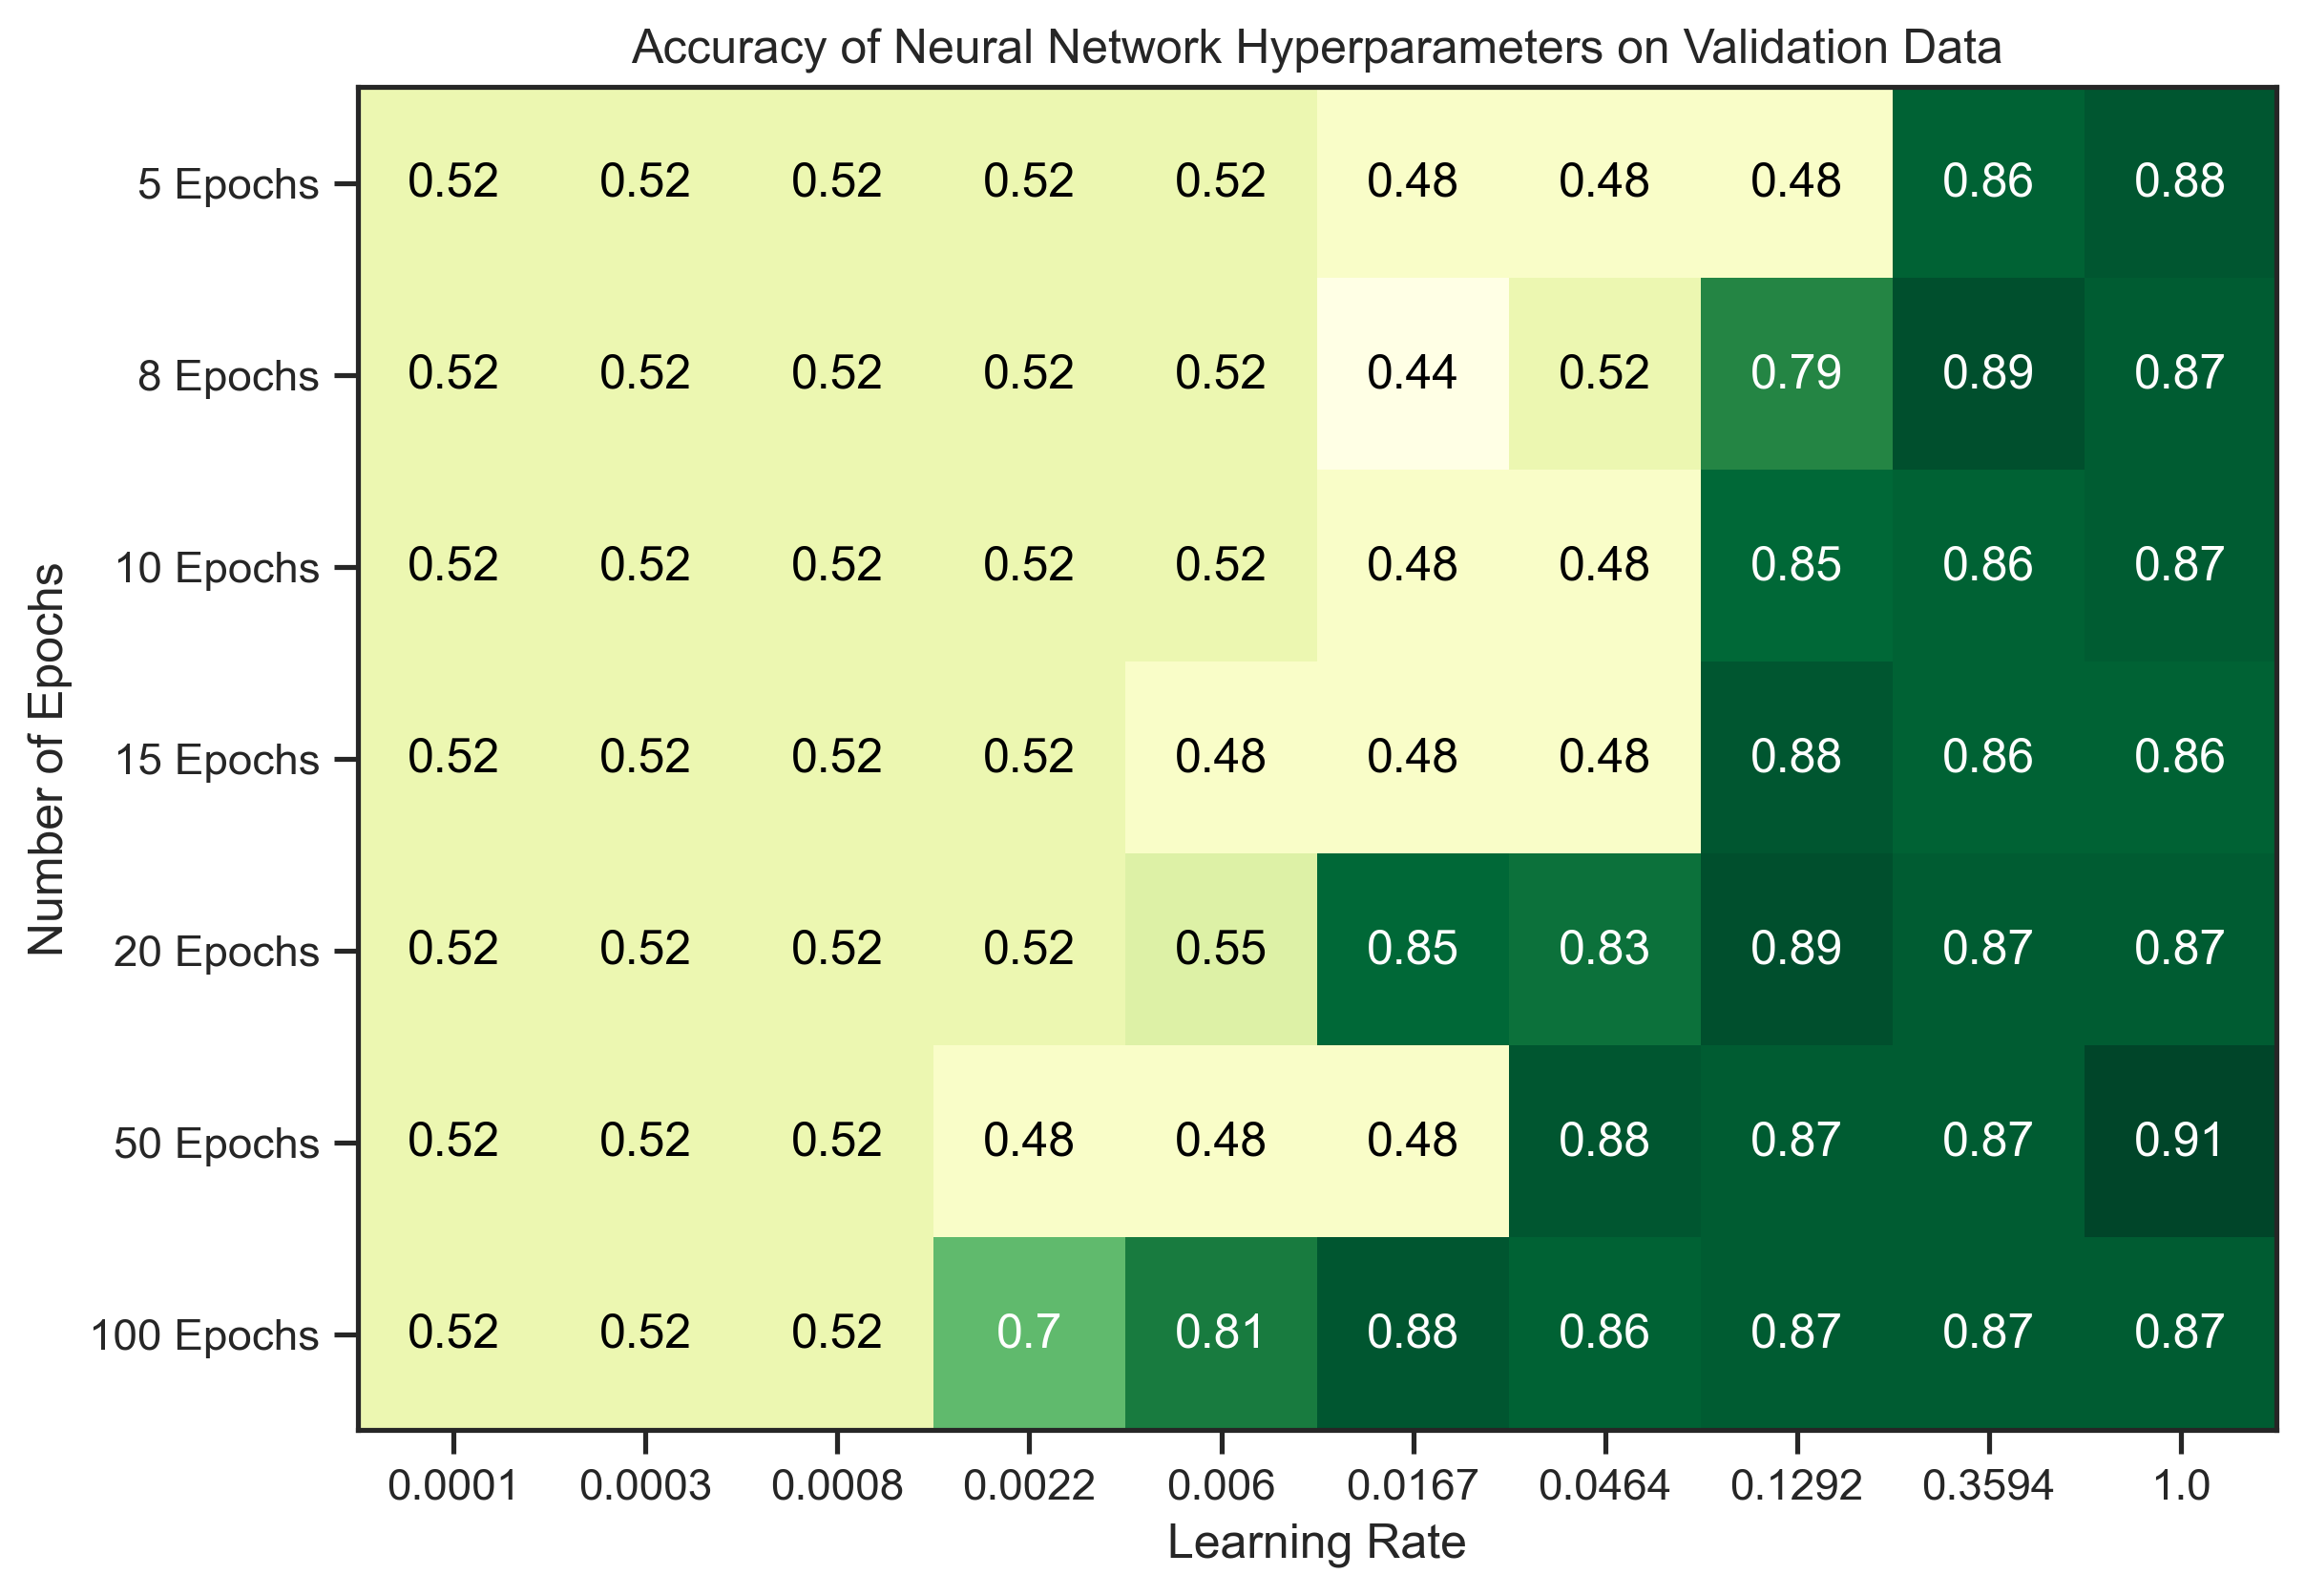

In [23]:
# Create figure and axis
fig, ax = plt.subplots(figsize = (8,8))
im = ax.imshow(accuracy_matrix, cmap="YlGn")

# Set ticks and labels
ax.set_yticks(
    np.arange(accuracy_matrix.shape[0]),
    labels=[
        "5 Epochs",
        "8 Epochs",
        "10 Epochs",
        "15 Epochs",
        "20 Epochs",
        "50 Epochs",
        "100 Epochs"
    ]
)
ax.set_xticks(
    np.arange(accuracy_matrix.shape[1]), 
    labels=list(learning_rate_dist.round(4))
)

# Get threshold to set text colors
threshold = im.norm(accuracy_matrix.max()) / 2

# Set text annotation of heatmap
textcolors = ("black", "white")
for i in range(len(epochs)):
    for j in range(len(learning_rate_dist)):
        text = ax.text(
            j,
            i,
            accuracy_matrix[i, j].round(5),
            ha="center",
            va="center",
            color=textcolors[int(im.norm(accuracy_matrix[i, j]) > threshold)],
        )

fig.tight_layout()
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Number of Epochs")
ax.set_title("Accuracy of Neural Network Hyperparameters on Validation Data")
plt.show()


> Referencing the heatmap above, we opt to choose the hyperparameters that gave us the highest accuracy on validation data: where learning rate = 1 and number of epochs = 50.

**Plotting Cost Function**


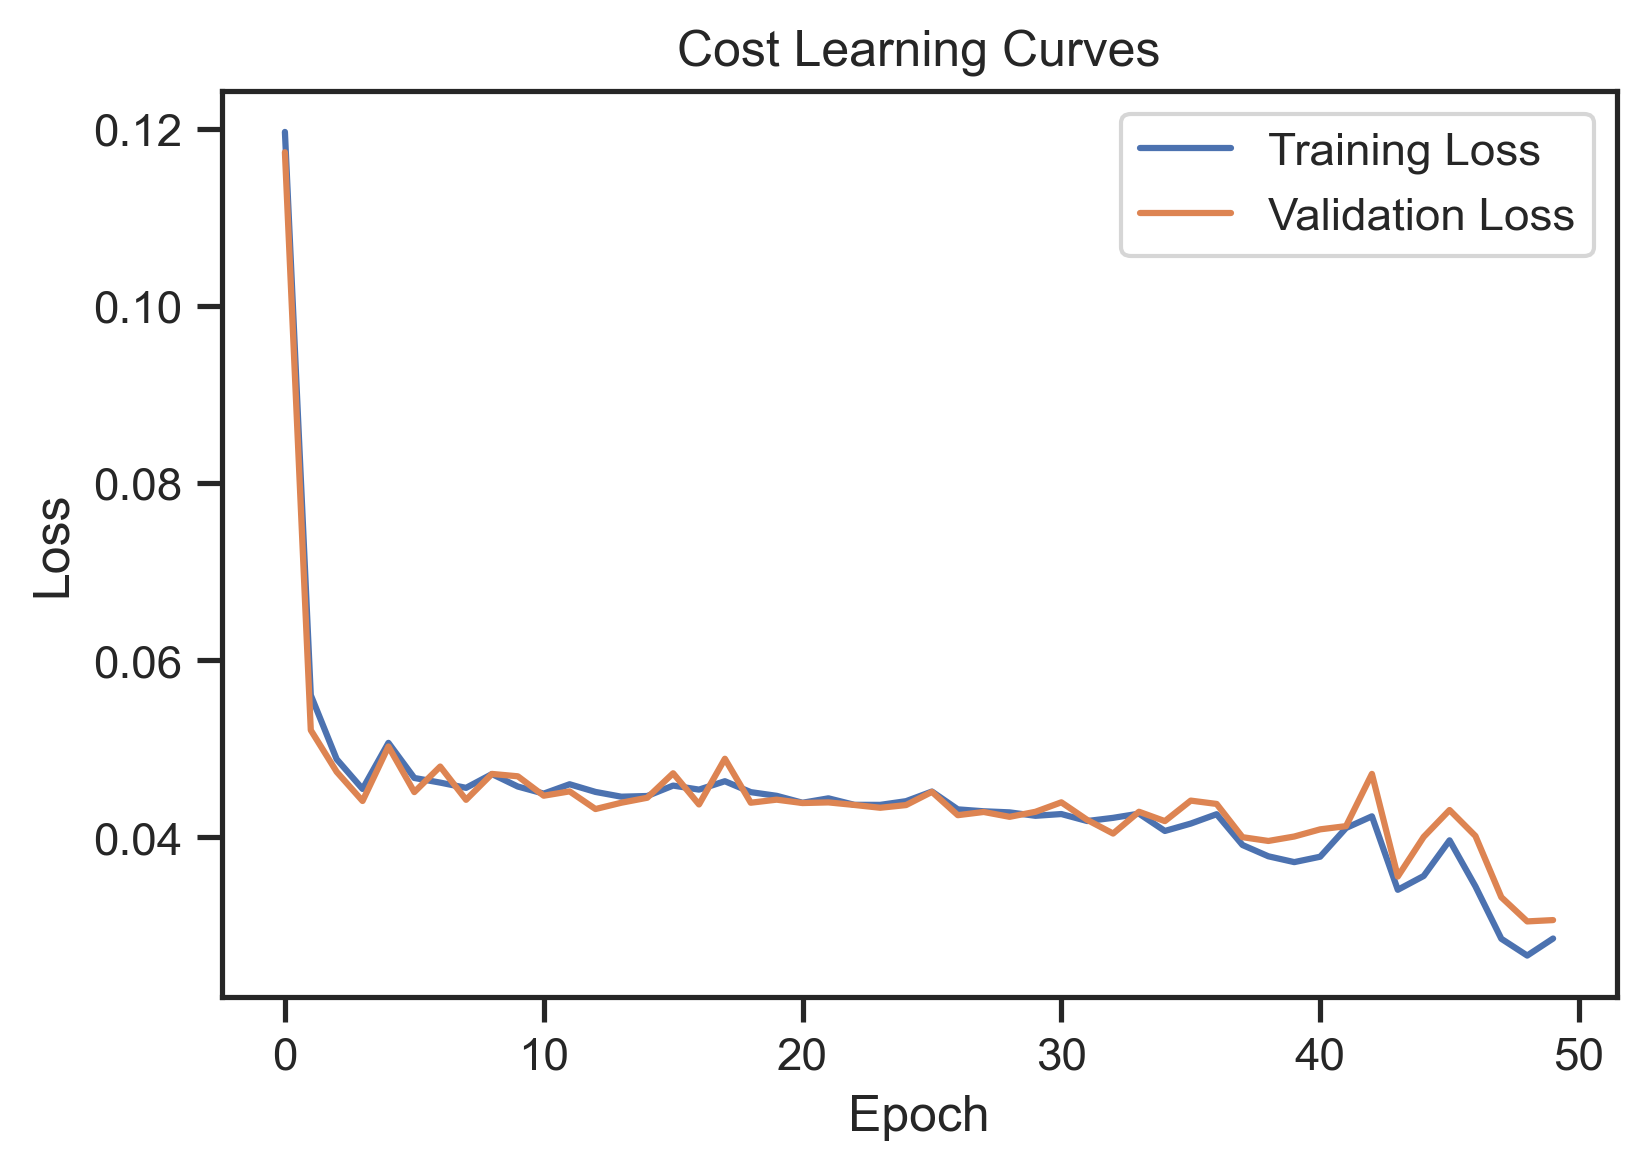

In [29]:
np.random.seed(4)
best_nnet = myNeuralNetwork(
    n_in=2,
    n_layer1=5,
    n_layer2=5,
    n_out=1,
    learning_rate=1
)
best_nnet.fit(
    X_train, y_train,
    max_epochs=50,
    get_validation_loss=True,
    X_validation=X_val,
    y_validation=y_val,
    random_state=4
)

# Get the training and validation loss functions
training_errors_best_nnet = best_nnet.train_loss
validation_errors_best_nnet = best_nnet.validation_loss

# Plot the loss as a function of number of epochs
fig, ax = plt.subplots()
sns.lineplot(
    training_errors_best_nnet,
    legend='brief',
    label = "Training Loss",
    ax = ax
)
sns.lineplot(
    validation_errors_best_nnet,
    legend='brief',
    label = "Validation Loss",
    ax = ax, 
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Cost Learning Curves")
plt.show()

**Plot decision boundaries**

In [25]:
## Define a decision boundary function for our neural network 
def draw_decision_boundary_nnet(model, X, y, ax, xlabel, ylabel):
    """Draws decision boundary of a myNeuralNetwork model with X, y
    data, the axis to plot the graph on, as well as xlabel
    and ylabel for the plot"""
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:,0].min()-1, X[:,0].max()+1, num=1000),
        np.linspace(X[:,1].min()-1, X[:,1].max()+1, num=1000),
    )

    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(model.predict(grid), feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1,
         xx1=feature_2, 
         response=y_pred)
    display.plot(ax=ax, xlabel=xlabel, ylabel=ylabel, cmap=cmap_light)
    sns.scatterplot(
        x=X[:,0],
        y=X[:,1],
        hue=y,
        ax=ax,
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )


> Using the helper function, we can plot the decision boundaries of our tuned model on both training and validation data.

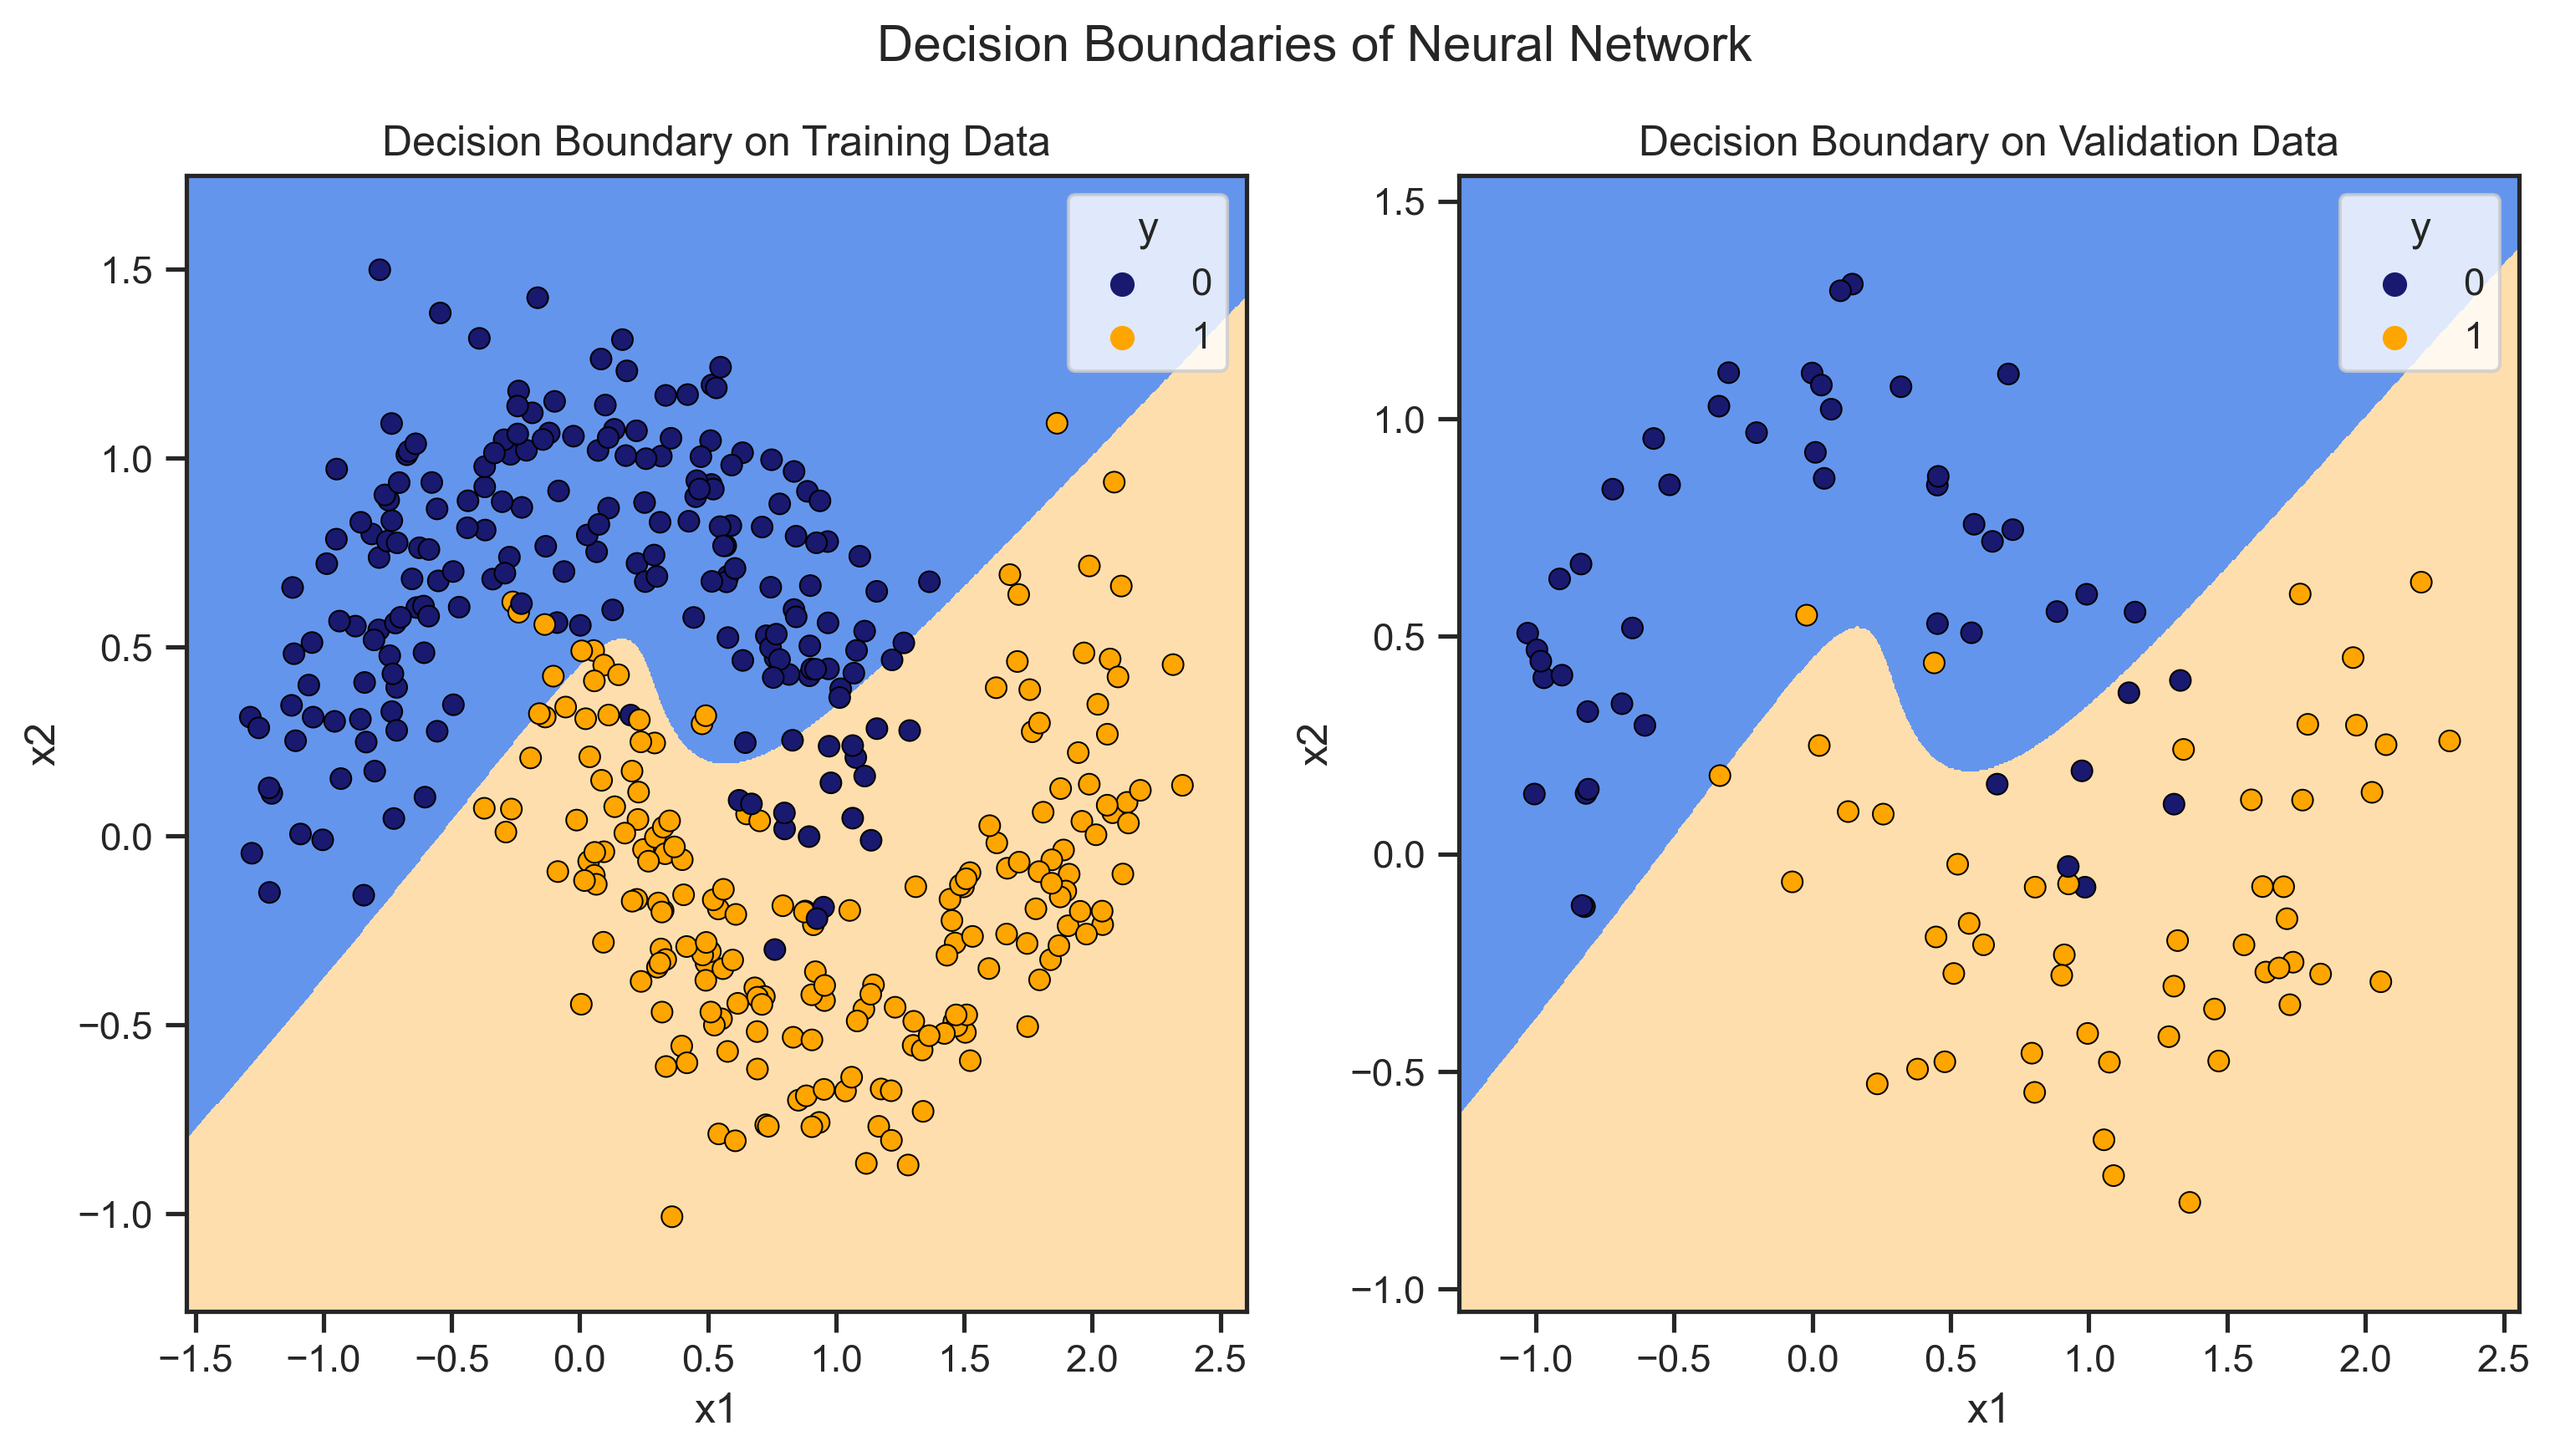

In [26]:
# Plot the decision boundaries
fig, axes = plt.subplots(1, 2, figsize = (12,6))
draw_decision_boundary_nnet(
    best_nnet,
    X_train,
    y_train,
    axes[0],
    "x1",
    "x2"
)
axes[0].set_xlim(X_train[:,0].min()-.25, X_train[:,0].max()+.25)
axes[0].set_ylim(X_train[:,1].min()-.25, X_train[:,1].max()+.25)
axes[0].legend(title = 'y')
axes[0].set_title("Decision Boundary on Training Data")
draw_decision_boundary_nnet(
    best_nnet,
    X_val,
    y_val,
    axes[1],
    "x1",
    "x2"
)
axes[1].set_xlim(X_val[:,0].min()-.25, X_val[:,0].max()+.25)
axes[1].set_ylim(X_val[:,1].min()-.25, X_val[:,1].max()+.25)
axes[1].legend(title = 'y')
axes[1].set_title("Decision Boundary on Validation Data")
fig.suptitle("Decision Boundaries of Neural Network")
plt.show()

> We see from the above plots that the neural network model has learned, albeit imperfectly, the moon-like shape of the true decision boundary between class 0 and class 1. 

**ROC Curves**

In [27]:
# Build the MLP Model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(5,5),
    learning_rate_init=1,
    alpha=0,
    solver="sgd",
    random_state=4
).fit(X_train_plus_val, y_train_plus_val)

# Build the full neural network model
best_nnet_full = myNeuralNetwork(
    n_in=2,
    n_layer1=5,
    n_layer2=5,
    n_out=1,
    learning_rate=1
)
best_nnet_full.fit(
    X = X_train_plus_val, 
    y = y_train_plus_val,
    max_epochs=50,
    random_state=4
)


> Using the constructed MLP classifier and the Neural Network, we can plot the ROC curves of both models and the chance diagonal.

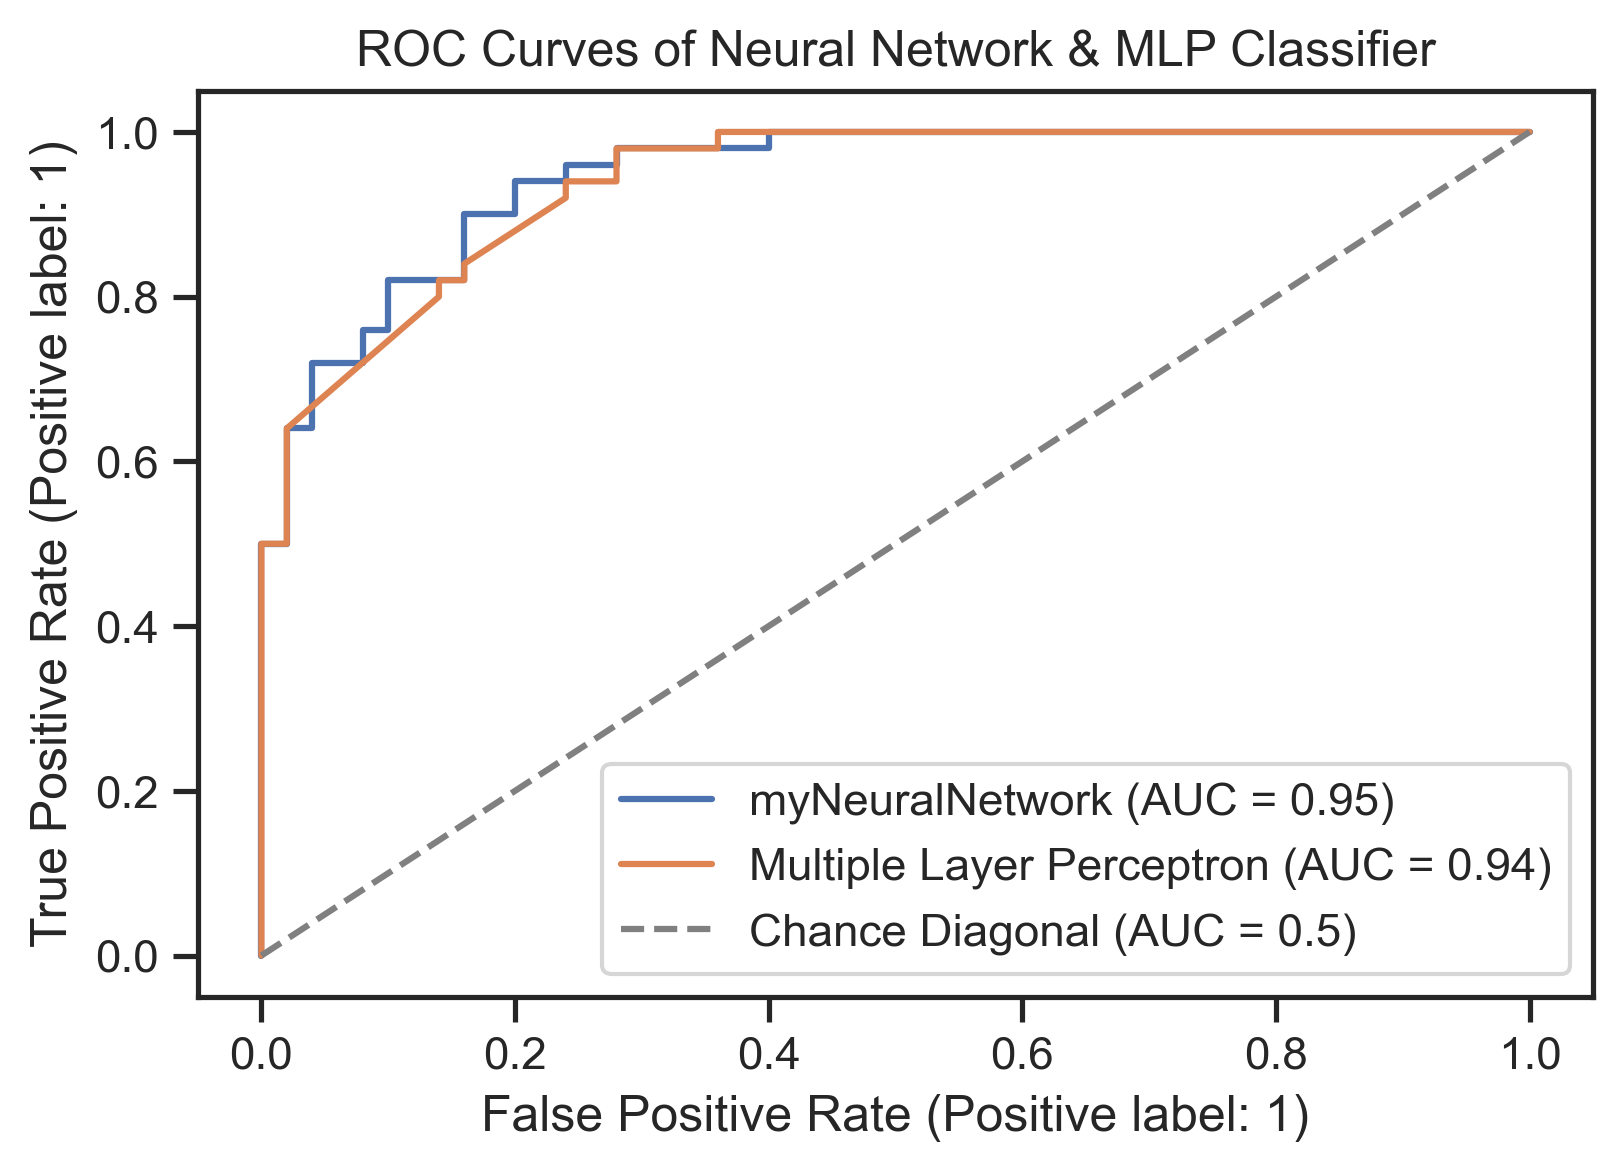

In [28]:
# Plot the ROC Curves of the MLP and NNet models
from sklearn.metrics import RocCurveDisplay
nnet_predictions = best_nnet_full.predict_proba(X_test)

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    y_true=y_test, y_pred=nnet_predictions, 
    ax=ax, name="myNeuralNetwork"
)
RocCurveDisplay.from_estimator(
    mlp_model, X_test, y_test,
    name = "Multiple Layer Perceptron",
    ax = ax
)
plt.plot(
    chance[:, 0], chance[:, 1], linestyle="dashed", 
    c="gray", label="Chance Diagonal (AUC = 0.5)"
)
plt.title("ROC Curves of Neural Network & MLP Classifier")
plt.legend()
plt.show()

> As we can see in the plot above, our Neural Network performed on par but slightly better than the Multiple Layer Perceptron model. Depending on the trade-off between false positive rates and true positive rates however, we may choose one model over the other. If total accuracy is important, we will likely choose our custom Neural Network because it is closer to the upper-left corner of the plot and has a slightly higher AUC. However, if True Positive Rate is really important, we may opt for the MLP model instead because it's able to reach a 100% True Positive Rate with a slightly lower False Positive Rate.

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

> One way we can improve our network model could be to add more layers to the neural network. Looking at the decision boundaries, we find that there are corners of the data that our decision boundary could be more flexible at predicting, and increasing the number of layers will likely help with that. Alternatively, we could also add a bias term for each of our Z vectors.
>
> Another way we can improve our network model could be to try using a ReLU activation function instead of a sigmoid one, or using a cross-entropy loss function instead of a MSE based loss function.